**КАКОЙ КЕЙС РЕШАЕМ?**

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Первоначальная версия датасета содержит 17 полей со следующей информацией:
1. hotel_address — адрес отеля;
2. review_date — дата, когда рецензент разместил соответствующий отзыв;
3. average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
4. hotel_name — название отеля;
5. reviewer_nationality — страна рецензента;
6. negative_review — отрицательный отзыв, который рецензент дал отелю;
7. review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
8. positive_review — положительный отзыв, который рецензент дал отелю;
9. review_total_positive_word_counts — общее количество слов в положительном отзыве.\
10. reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
11. total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
12. total_number_of_reviews — общее количество действительных отзывов об отеле;
13. tags — теги, которые рецензент дал отелю;
14. days_since_review — количество дней между датой проверки и датой очистки;
15. additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. lat — географическая широта отеля;
17. lng — географическая долгота отеля.

In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from geopy.distance import geodesic

from category_encoders import OneHotEncoder

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
INPUT_DIR = './data/'
import os
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/hotels_test.csv
./data/hotels_train.csv
./data/submission.csv


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [150]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [151]:
# Подгрузим наши данные из соревнования

# подгружаем данные из соревнования

# датасет для обучения
df_train = pd.read_csv(INPUT_DIR + '/hotels_train.csv')

# датасет для предсказания
df_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')

# тестовый сабмишн
sample_submission = pd.read_csv(INPUT_DIR + '/submission.csv')

In [152]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  reviewer_score                              float64
 13  tags                         

In [153]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [154]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  tags                                        object 
 13  days_since_review            

In [155]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [156]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [157]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Dtype
---  ------          -----
 0   reviewer_score  int64
 1   id              int64
dtypes: int64(2)
memory usage: 2.0 MB


In [158]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) #объединяем

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  tags                                        object 
 13  days_since_review            

Проверим датафрейм на наличие дубликатов:

In [160]:
print(data.duplicated().sum())
data[data.duplicated()].groupby('hotel_name').size()

336


hotel_name
Copthorne Tara Hotel London Kensington      1
Fletcher Hotel Amsterdam                    1
H tel Baume                                50
H tel Concorde Montparnasse               235
Hotel Da Vinci                              1
Hotel Le Sainte Beuve                      35
Mercure Paris Centre Tour Eiffel            1
Park Plaza Vondelpark Amsterdam             1
Pertschy Palais Hotel                       1
The Bloomsbury Hotel                        1
Villa Eugenie                               9
dtype: int64

Дубликатов не так много и они не должны оказать большое влияние. Оставим как есть.

Разберемся с пропущенными значениями. Видим проопущенные значения только в координатах 'lat' и 'lng'. Создадим список отелей, для которых они пропущены:

In [161]:
# Создаем список отелей, для которых пропущены координаты
missing_coordinates = data.groupby('hotel_address').filter(lambda x: pd.isna(x['lat']).any() or pd.isna(x['lng']).any())
missing_list = list(missing_coordinates['hotel_address'].unique())
print(len(missing_list))

17


Для 17 отелей пропущены коордианты, заполним их при помощи уже предварительно составленного словаря с адресами и их примерными координатами (при помощи библиотеки geopy). 

In [162]:
hotel_coordinates = {
        'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.2149546, 16.302153494876826],
        '23 Rue Damr mont 18th arr 75018 Paris France': [48.8870221, 2.3478318],
        'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.2108519, 16.347359861911986],
        'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848],
        '4 rue de la P pini re 8th arr 75008 Paris France': [48.8870221, 2.3478318],
        'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': [48.2048346, 16.3702081],
        'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.2006384, 16.426895311477978],
        'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.3936885, 2.1636552],
        'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848],
        'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.20254735, 16.38461641187194],
        'Paragonstra e 1 11 Simmering 1110 Vienna Austria': [48.16310865, 16.458012842051907],
        'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848],
        '20 Rue De La Ga t 14th arr 75014 Paris France': [48.8870221, 2.3478318],
        'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': [48.2048346, 16.3702081],
        'Sep lveda 180 Eixample 08011 Barcelona Spain': [41.3936885, 2.1636552],
        'Pau Clar s 122 Eixample 08009 Barcelona Spain': [41.3936885, 2.1636552],
        'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.2108519, 16.347359861911986]
}

In [163]:
# Функция для замены пропущенных значений
def paste_coordiantes(row):
    if pd.isna(row['lat']) and pd.isna(row['lng']):
        address = row['hotel_address']
        row['lat'] = hotel_coordinates[address][0]
        row['lng'] = hotel_coordinates[address][1]
    return row

In [164]:
# Заполняем пропущенные значения
data = data.apply(paste_coordiantes, axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  tags                                        object 
 13  days_since_review            

In [165]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.432399,2.893556,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.460244,4.667660,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214066,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.019886,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.841163,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.458013,1.000000,10.000000


In [166]:
data.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


Посмотрим на распределение целевой переменной:

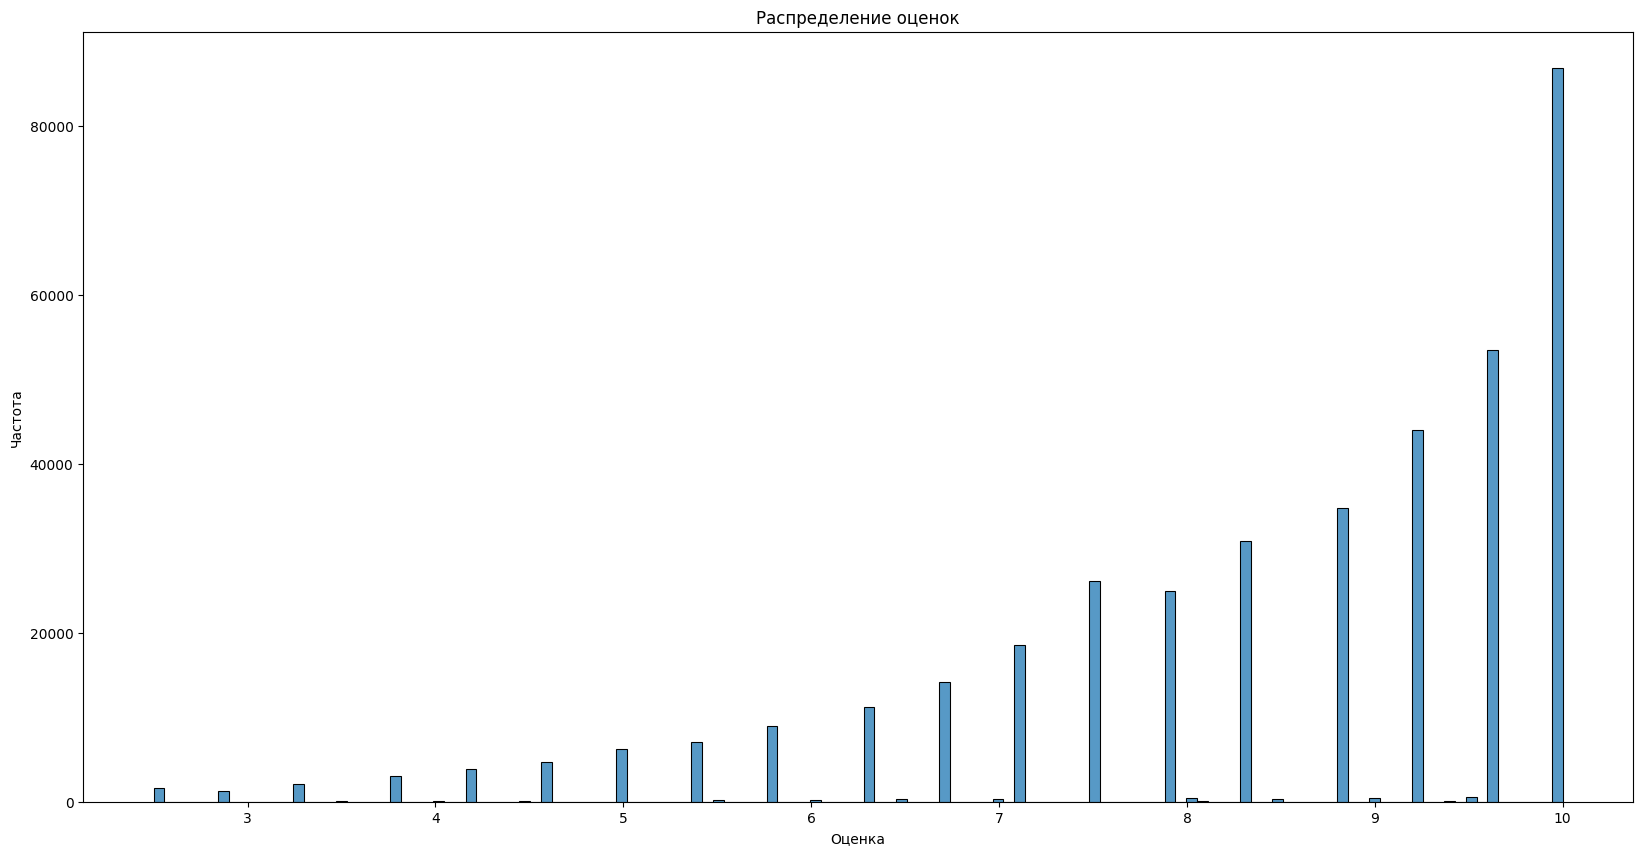

In [167]:
plt.figure(figsize=(20, 10))
sns.histplot(data=data[data['sample'] == 1], x='reviewer_score')

# Добавление заголовка и меток осей
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

# Показ гистограммы
plt.show()

Возрастающая гистограмма указывает на смещенность данных в сторону более высоких оценок. Большинство отзывов склонны к даванию более высоких оценок, чем низких.

# Проектирование признаков

## Адрес отеля

In [168]:
data['hotel_address'].sample(10)

57718     Wibautstraat 129 Oost 1091 GL Amsterdam Nether...
242659            5 Rue Belidor 17th arr 75017 Paris France
414382            Bergara 11 Eixample 08002 Barcelona Spain
324360           6 rue du Helder 9th arr 75009 Paris France
184631    28 30 Seymour Street Westminster Borough Londo...
367170    108 Baker Street Westminster Borough London W1...
312278    97 Great Russell Street Bloomsbury Camden Lond...
488671    Holland Park Avenue Kensington and Chelsea Lon...
258569    Gran Via de les Corts Catalanes 678 Eixample 0...
407206    The Strand Westminster Borough London WC2N 5HX...
Name: hotel_address, dtype: object

Пройдемся по каждому признаку и попробуем выделить из него дополнительную информацию. Начнем с адреса. Мы видим, что адрес содержит страну, город, индекс и сам адрес. Можем выделить страну и город:

In [169]:
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
data['country'].unique()

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

Всего в датасете представлено 6 стран

In [170]:
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-1] != 'Kingdom' else x.split()[-5])
data['city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

А в качестве городов их столицы

In [171]:
data['country']

0                  Italy
1            Netherlands
2                  Spain
3                  Italy
4            Netherlands
               ...      
515733    United Kingdom
515734           Austria
515735    United Kingdom
515736    United Kingdom
515737    United Kingdom
Name: country, Length: 515738, dtype: object

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   hotel_address                               object 
 1   additional_number_of_scoring                int64  
 2   review_date                                 object 
 3   average_score                               float64
 4   hotel_name                                  object 
 5   reviewer_nationality                        object 
 6   negative_review                             object 
 7   review_total_negative_word_counts           int64  
 8   total_number_of_reviews                     int64  
 9   positive_review                             object 
 10  review_total_positive_word_counts           int64  
 11  total_number_of_reviews_reviewer_has_given  int64  
 12  tags                                        object 
 13  days_since_review            

Посмотрим на распределение оценок в зависимости от стран:

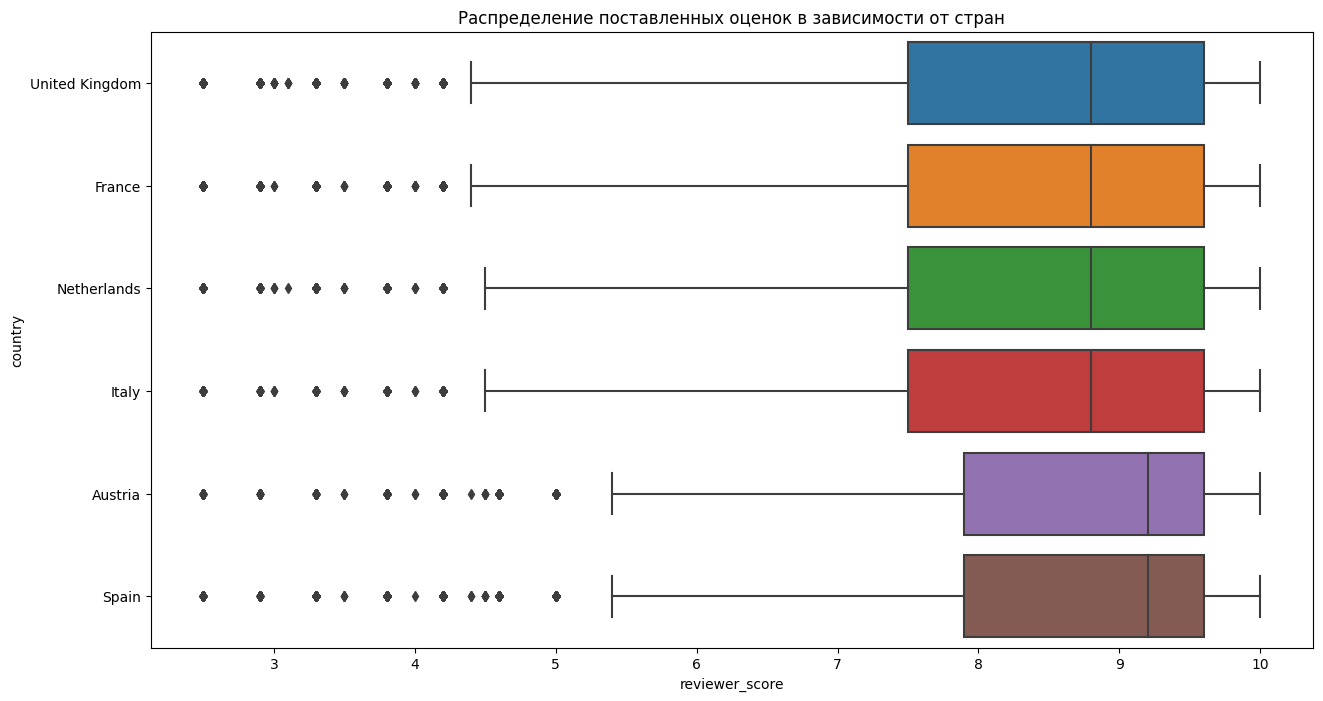

In [173]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data[data['sample'] == 1], y='country', x='reviewer_score', orient='h')
plt.title('Распределение поставленных оценок в зависимости от стран')
plt.show()

Видим, что для Австрии и Испании средняя оценка выше. Думаю, что страна полезный признак для обучения, а т.к. стран немного, то можно будет закодировать методом One-Hot Encoding 

Рассчитаем для каждого отеля расстояние до центра города. Этот фактор должен влиять на поставленную оценку туристом

In [174]:
cities = list(data['city'].unique())

Создадим словарь с координатами для центров:

In [175]:
center_coordinates = {'London': [51.5074456, -0.1277653],
 'Paris': [48.8534951, 2.3483915],
 'Amsterdam': [52.3730796, 4.8924534],
 'Milan': [45.4641943, 9.1896346],
 'Vienna': [48.2083537, 16.3725042],
 'Barcelona': [41.3828939, 2.1774322]}

In [176]:
# Функция, рассчитывающая расстояние от отеля до центра города в км
def distance_to_center(row):
    hotel_coordinates = [row['lat'], row['lng']]
    city_center_coordinates = center_coordinates.get(row['city'])
    distance = round(geodesic(hotel_coordinates, city_center_coordinates).kilometers,1)
    return distance

In [177]:
data['distance_to_center'] = data.apply(distance_to_center, axis=1)

In [178]:
data['distance_to_center'].describe()

count    515738.000000
mean          3.150130
std           2.566252
min           0.000000
25%           1.300000
50%           2.500000
75%           4.100000
max          17.200000
Name: distance_to_center, dtype: float64

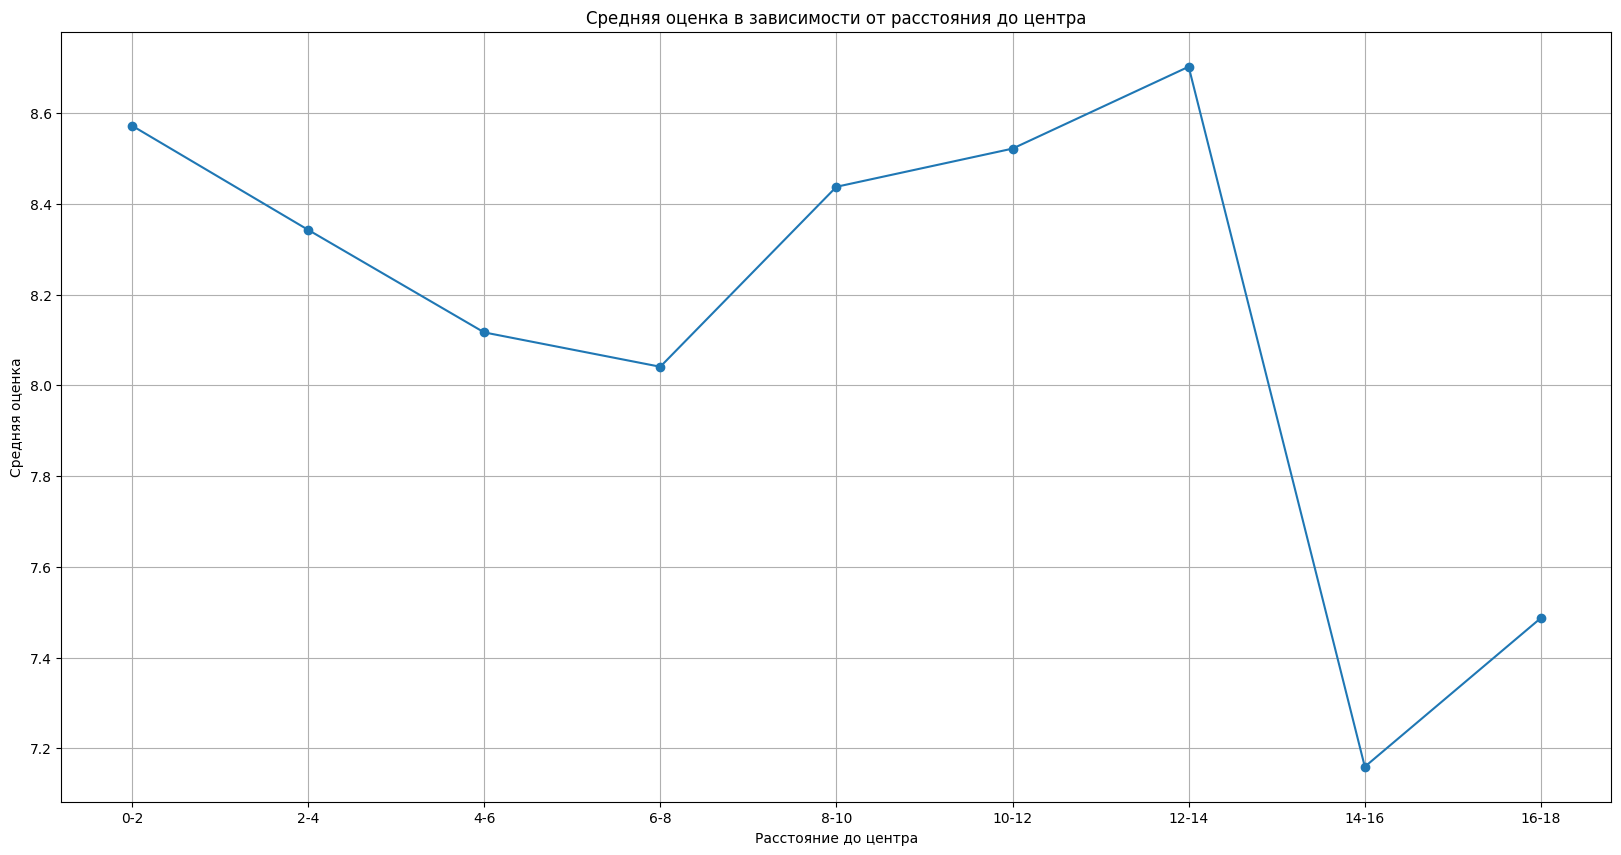

In [179]:
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]  # задаем интервалы по 2 км
labels = ['0-2', '2-4', '4-6', '6-8', '8-10','10-12', '12-14', '14-16', '16-18']  # метки для интервалов

# Группировка данных по интервалам расстояний и расчет средней оценки по каждому интервалу
fig_distance = data[data['sample'] == 1].groupby(pd.cut(data[data['sample'] == 1]['distance_to_center'], bins=bins, labels=labels))['reviewer_score'].mean().reset_index()

# Построение графика
plt.figure(figsize=(20, 10))
plt.plot(fig_distance['distance_to_center'], fig_distance['reviewer_score'], marker='o')
plt.title('Средняя оценка в зависимости от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Средняя оценка')
plt.grid(True)
plt.show()

По графику видно, что есть спад по мере удаления от центра, но затем снова идет рост. Возможно, ценник на на отели, которые расположены дальше от центра ниже, но условия могут быть даже лучше. Еще дальше - оценки уже ниже. Думаю это полезный признак для обучения.

## Дата

Информация, представленная в датах:
* Дата размещения отзыва ('review_date')
* Разница между датой отзыва и датой выгрузки данных ('days_since_review')

Рассмотрим распределение оценок по месяцам, году и кварталу:

In [180]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year
data['quarter'] = data['review_date'].dt.quarter

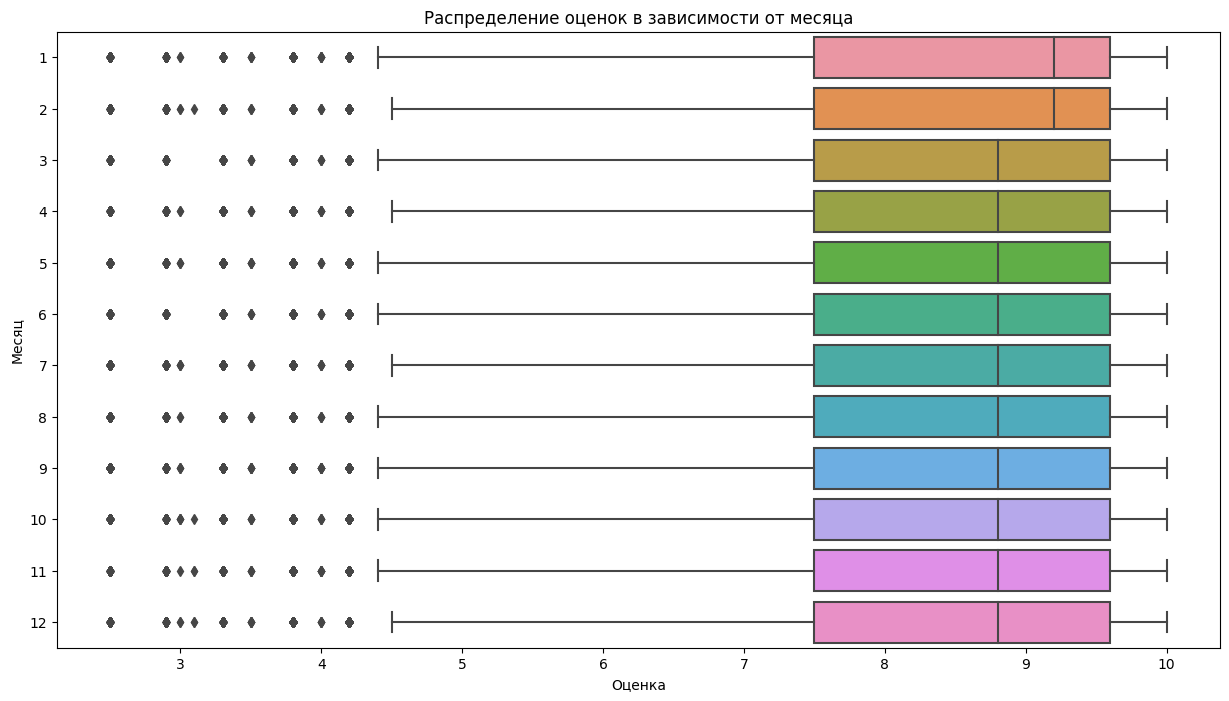

In [181]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='month',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от месяца')
plt.xlabel('Оценка')
plt.ylabel('Месяц')
plt.show()

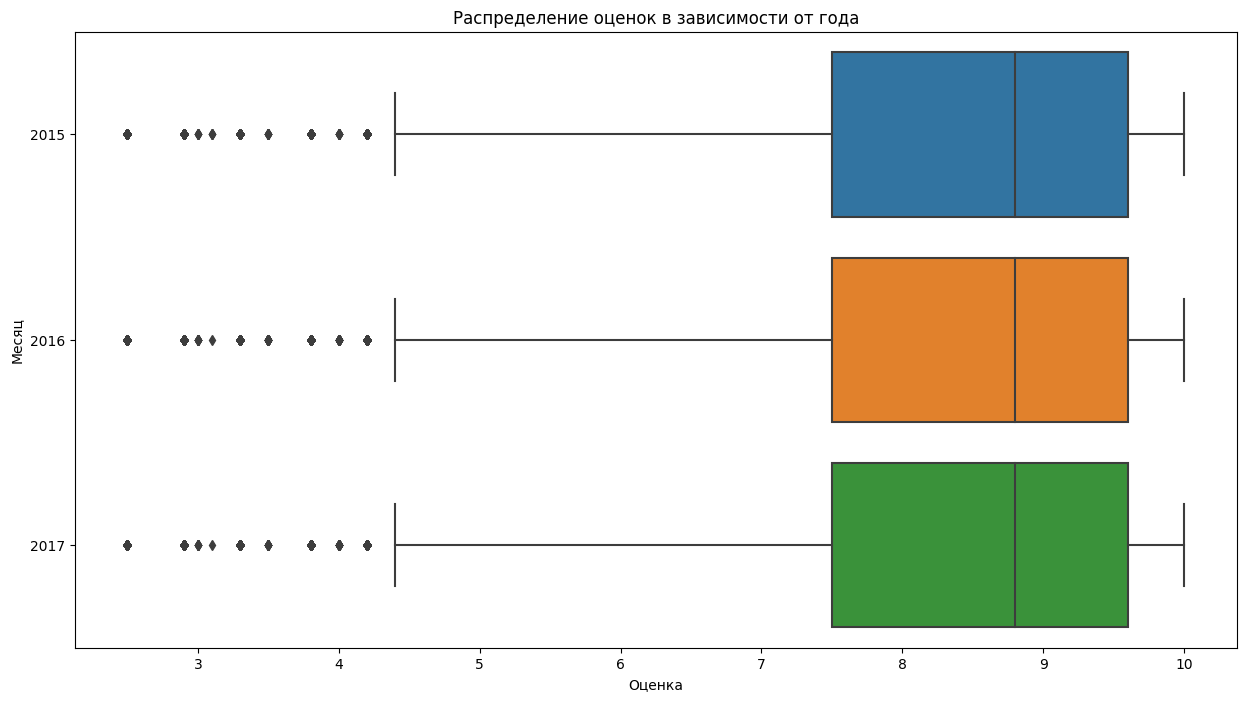

In [182]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='year',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от года')
plt.xlabel('Оценка')
plt.ylabel('Месяц')
plt.show()

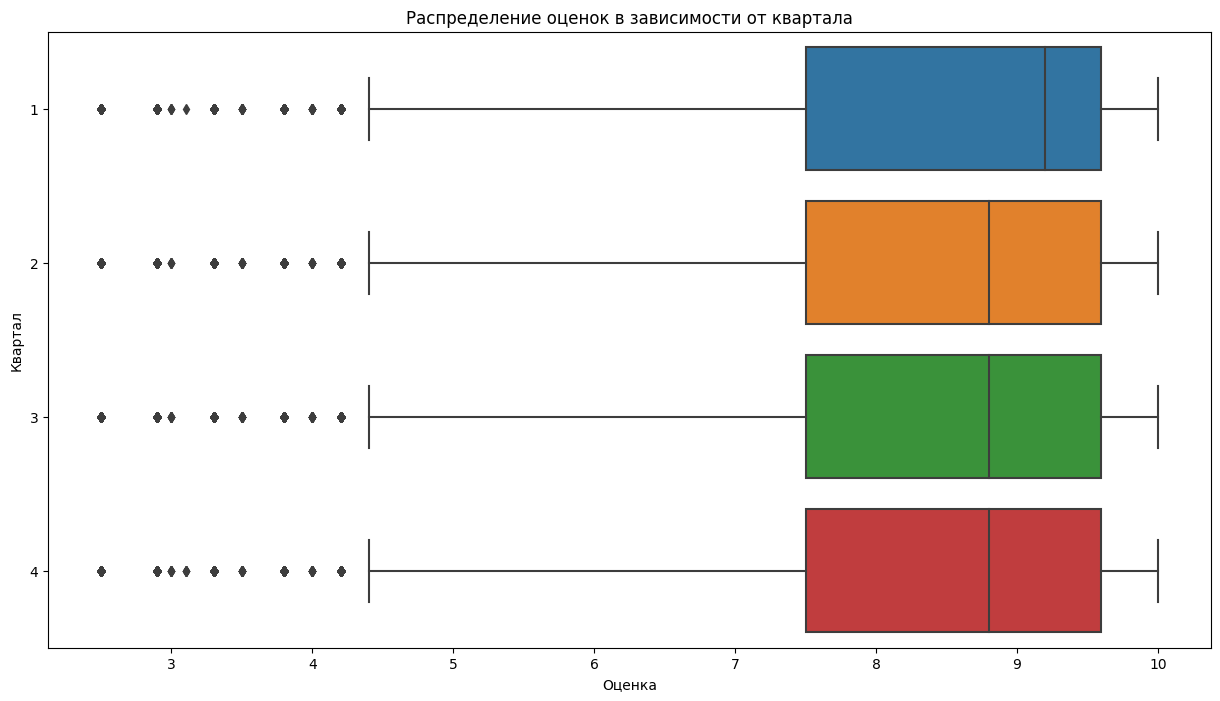

In [183]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='quarter',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от квартала')
plt.xlabel('Оценка')
plt.ylabel('Квартал')
plt.show()

Видно, что отличие в оценках идет для первого квартала. Возможно на это влияет новогодние каникулы и начало нового года. У людей может быть более приподнятое настроение) Думаю взять для обучения только признак квартала.

Признак - Разница между датой отзыва и датой выгрузки данных ('days_since_review'). Показывает свежесть отзыва. Возможно имеет смысл, если отель например делал ремонт и разные отзывы по времени имеют разный характер. Выделим из нее только число

In [184]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

## Текст отзыва

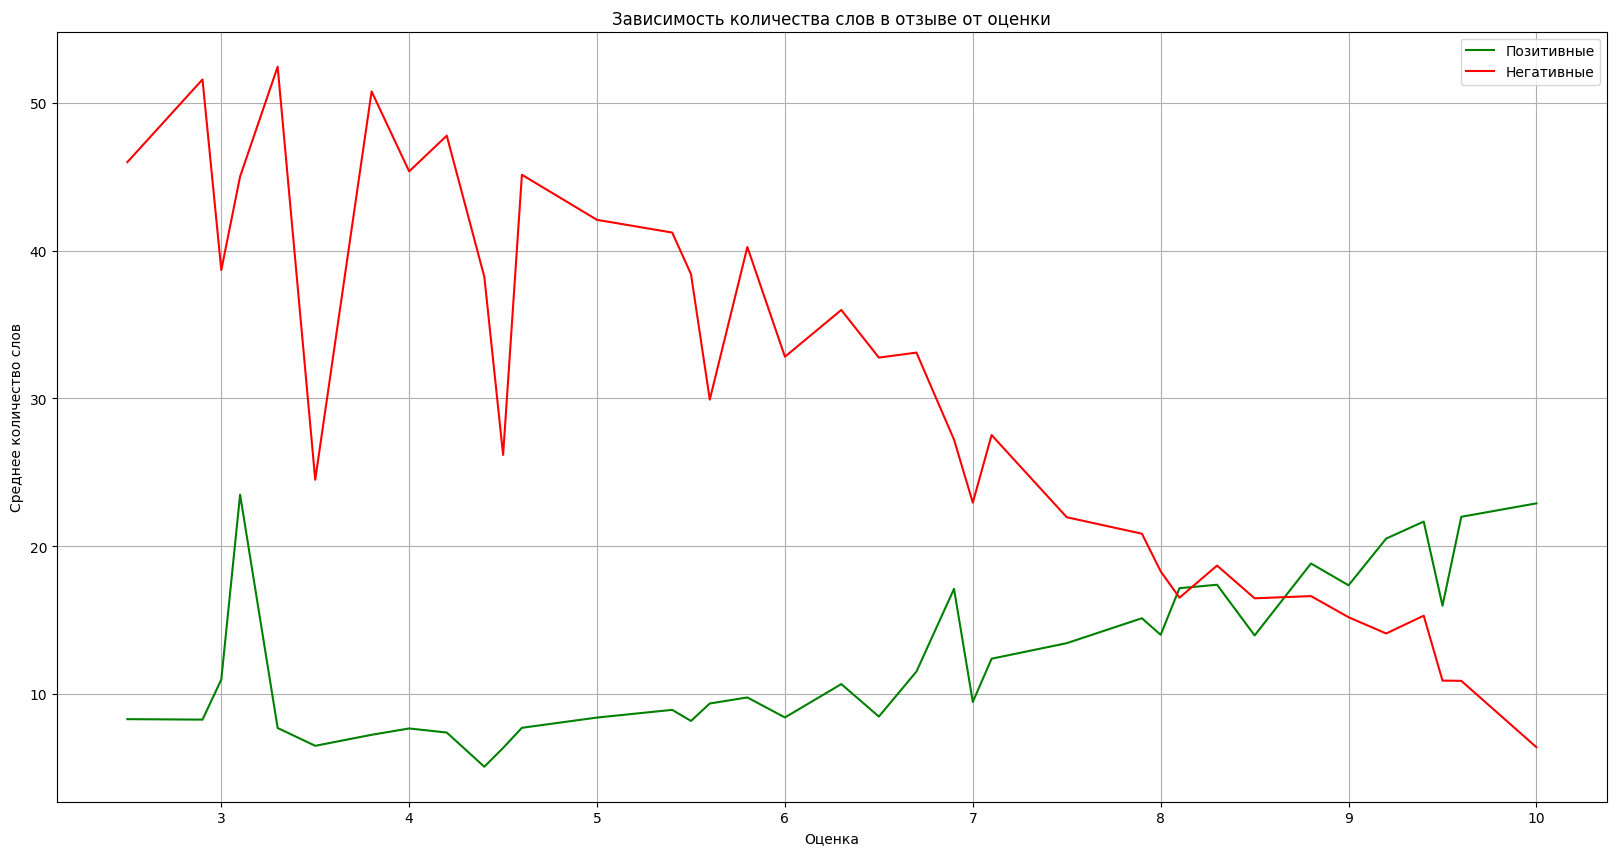

In [185]:
# Маска
filtered_data = data[data['sample'] == 1]

# Создание pivot table для среднего количества слов в отзывах по оценке и типу отзыва
pivot_table = filtered_data.pivot_table(index='reviewer_score', 
                                        values=['review_total_positive_word_counts', 'review_total_negative_word_counts'], 
                                        aggfunc='mean')

plt.figure(figsize=(20,10))
plt.plot(pivot_table.index,
         pivot_table['review_total_positive_word_counts'],
         color='green',
         label='Позитивные')
plt.plot(pivot_table.index,
         pivot_table['review_total_negative_word_counts'],
         color='red',
         label='Негативные')
plt.legend()
plt.xlabel('Оценка')
plt.ylabel('Среднее количество слов')
plt.title('Зависимость количества слов в отзыве от оценки')
plt.grid(True)
plt.show()

In [186]:
data[['negative_review','review_total_negative_word_counts','positive_review', 'review_total_positive_word_counts']].sample(5)

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
198585,No Negative,0,The staff is the best Second tone I have stay...,16
202029,Little bit out of the way for us but depends ...,19,Fantastic views from the top floor restaurant...,15
254233,Reception gave a biased response on the avail...,33,The room was nice and very clean Breakfast wa...,18
511958,The cost of the drinks were high,8,Bed was comfy,4
236129,Shower room needs a bit of T L C Carpet in Be...,16,Great Breakfast,3


In [187]:
data[['negative_review','review_total_negative_word_counts','positive_review', 'review_total_positive_word_counts']].describe(include='object')

,negative_review,positive_review
count,515738,515738
unique,330011,412601
top,No Negative,No Positive
freq,127890,35946


Создадим признак - разница между положительными словами и отрицательными:

In [191]:
data['positive_to_negative_diff'] = data.apply(lambda row: row['review_total_positive_word_counts'] - row['review_total_negative_word_counts'])

KeyError: 'review_total_positive_word_counts'

In [190]:
plt.figure(figsize=(25, 10))

plt.scatter(data['reviewer_score'][data['sample'] == 1],
            data['positive_to_negative_diff'][data['sample'] == 1],
            alpha=0.5)
plt.xlabel('Поставленная оценка')
plt.ylabel('Отношение положительных к отрицательным словам')
plt.title('Разница между количеством положительных слов и отрицательных в зависимости от оценки')
plt.grid(True)
plt.show()

KeyError: 'positive_to_negative_diff'

<Figure size 2500x1000 with 0 Axes>

Наиболее встречающиеся отзывы это No Negative, No Positive. Количество слов в таких отзывах равно 0. Тогда как в развернутых ответах количество слов в столбцах 'review_total_negative_word_counts', 'review_total_positive_word_counts' отличается от фактических на 1 или 2 слова. Не думаю, что это критично, для модели. Также чаще всего люди пишут больше негативного, даже если ставят высокую оценку, они подробно распишут, что им не понравилось.

Также я обратила внимание, что есть несколько отзывов с большим положительным отзывом, но оценку ставят низкую. Посмотрев эти записи, можно сказать, что люди просто перепутали поля и написали в положительном поле свой отрицательный опыт. 
Есть отзывы, где люди всем довольны, но оценку ставят среднюю, но делают это скорее всего осознанно

Я думаю отзыв - это важный фактор при приогнозировании оценки. Попробуем оценить тональность текста при помощи NLTK:

In [ ]:
# загружаем словарь лексикона VADER
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Так как no positive имеет отрицательный смысл, но анализатор текста воспримет слово'positive' как положительное, то заменим No Negative -  на Positive и наоборот.

In [ ]:
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [ ]:
# Функция для анализа тональности отрицательного отзыва
def sent_analize_neg(row):
    sent_dict = sent_analyzer.polarity_scores(row['negative_review'])
    row['neg_pos_rev'] = sent_dict['pos']
    row['neg_neg_rev'] = sent_dict['neg']
    row['neg_neu_rev'] = sent_dict['neu']
    row['neg_compound_rev'] = sent_dict['compound']
    return row

In [ ]:
# Функция для анализа тональности положительного отзыва
def sent_analize_pos(row):
    sent_dict = sent_analyzer.polarity_scores(row['positive_review'])
    row['pos_pos_rev'] = sent_dict['pos']
    row['pos_neg_rev'] = sent_dict['neg']
    row['pos_neu_rev'] = sent_dict['neu']
    row['pos_compound_rev'] = sent_dict['compound']
    return row

In [ ]:
data = data.apply(sent_analize_neg, axis=1)
data = data.apply(sent_analize_pos, axis=1)

In [ ]:
# Копирую результат после выполнения самой долгой ячейки
data_copy1 = data.copy()

## Национальность

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [ ]:
print(data['reviewer_nationality'].nunique())
print(data['reviewer_nationality'].value_counts().nlargest(20))

227
reviewer_nationality
 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: count, dtype: int64


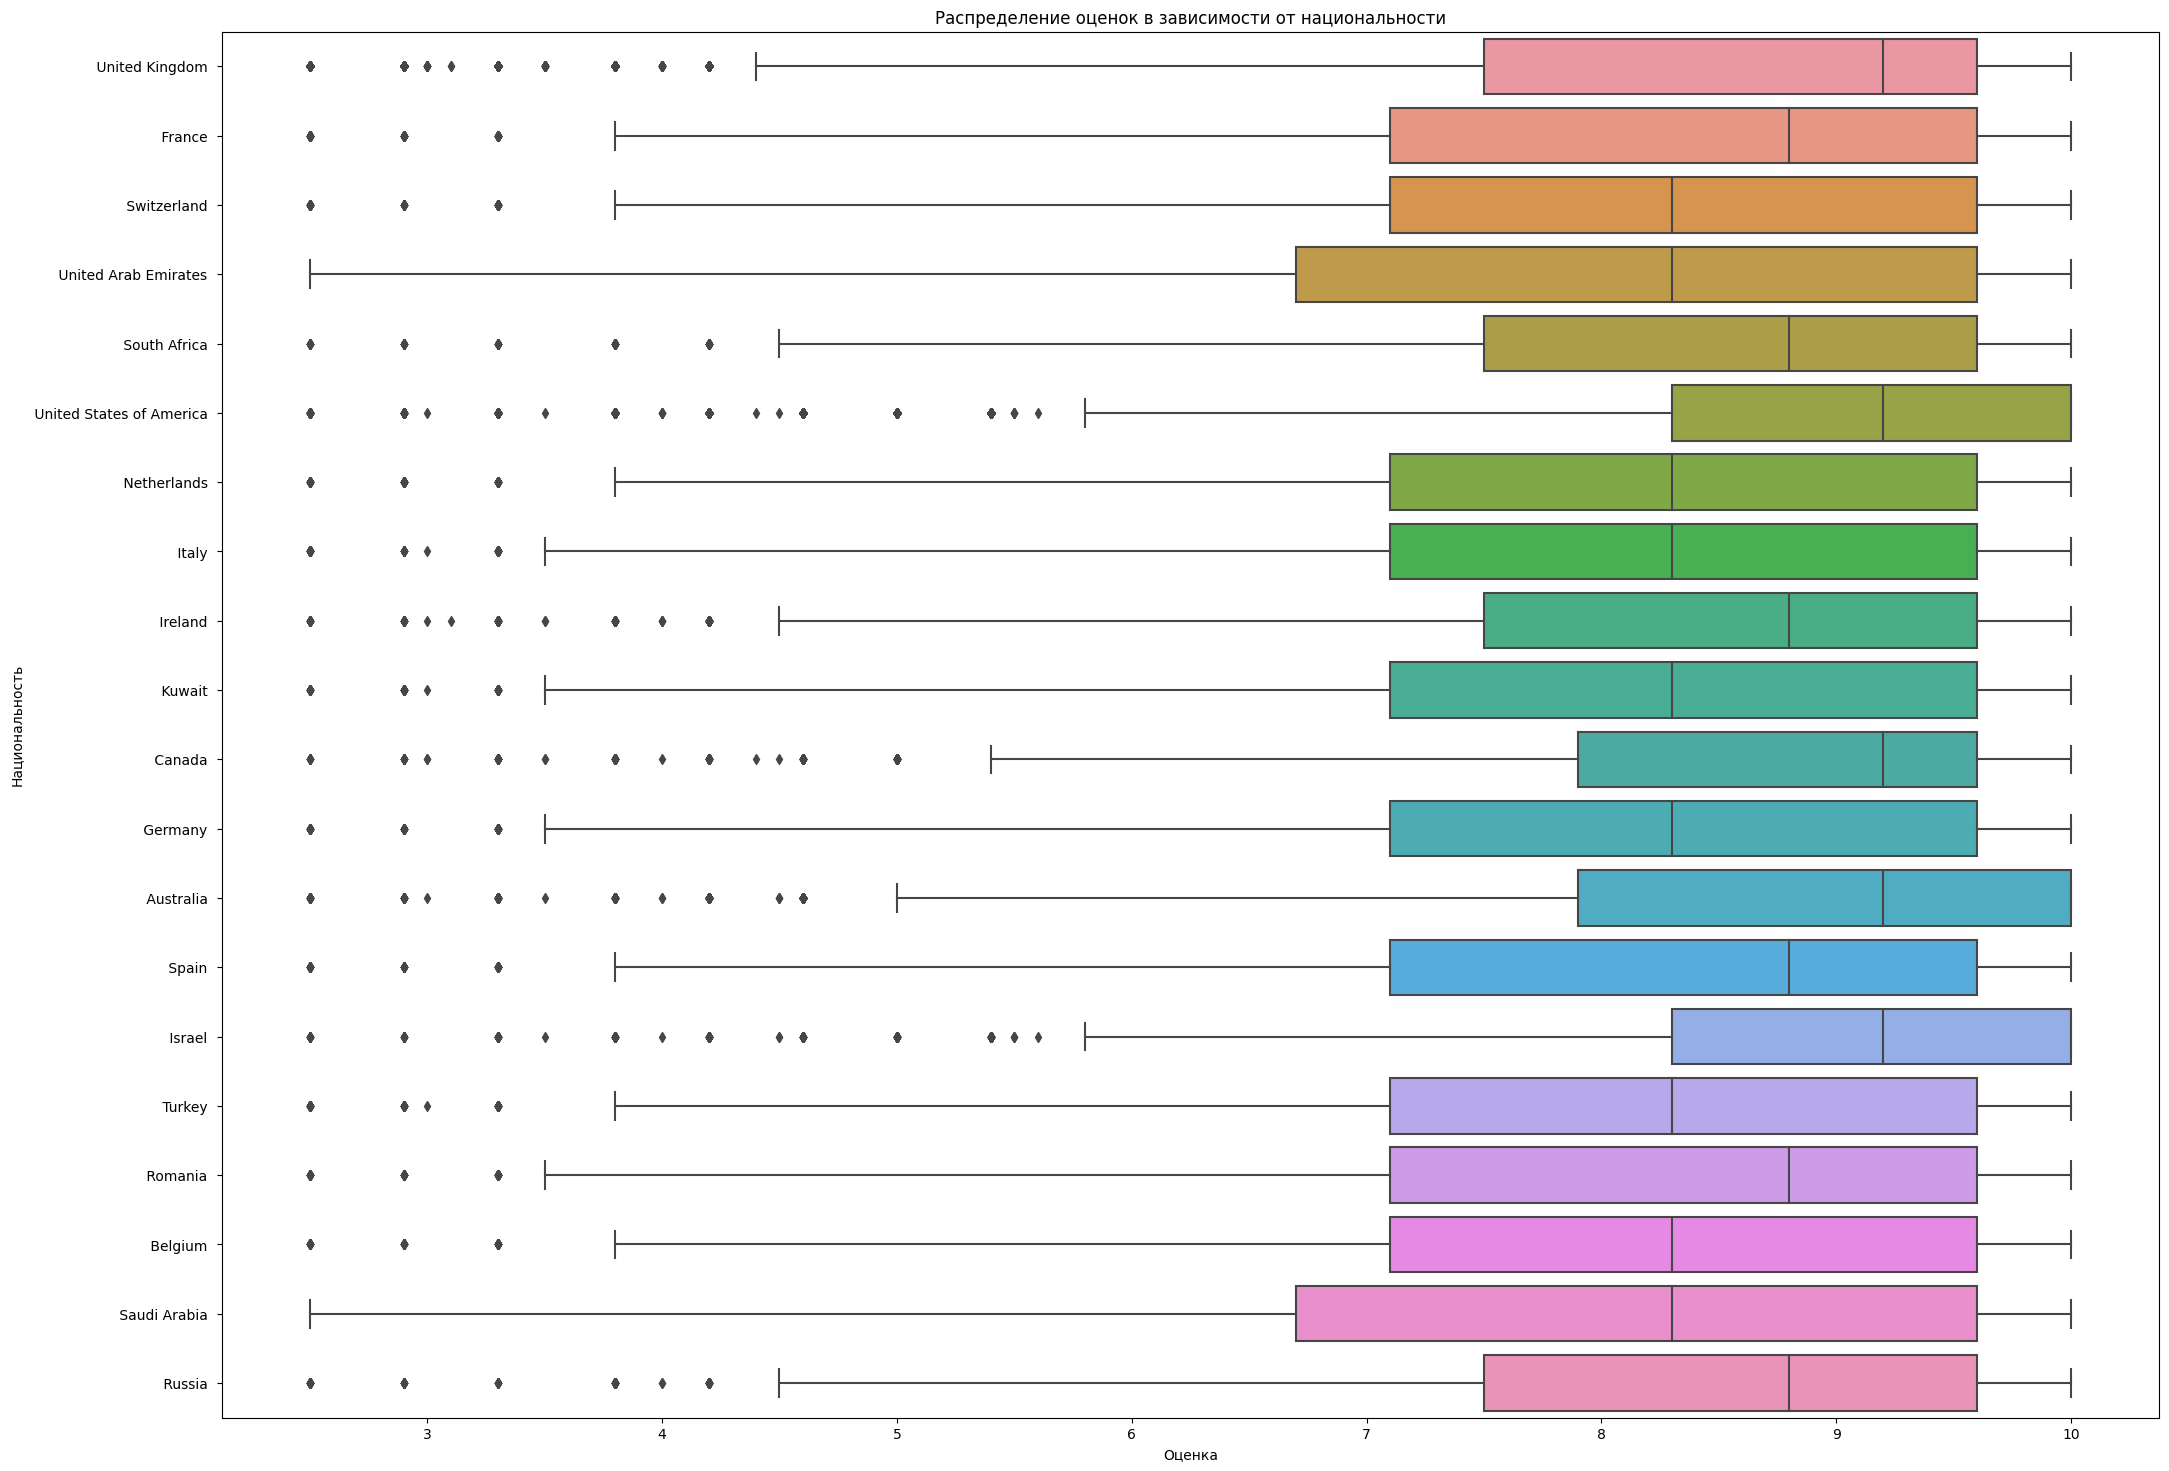

In [ ]:
top_20_nationalities = filtered_data['reviewer_nationality'].value_counts().nlargest(20).index
plt.figure(figsize=(25,18))
sns.boxplot(
    data = filtered_data[filtered_data['reviewer_nationality'].isin(top_20_nationalities)],
    x='reviewer_score',
    y='reviewer_nationality',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от национальности')
plt.xlabel('Оценка')
plt.ylabel('Национальность')
plt.show()

Всего в датасете представлено 227 национальностей. Средняя оценка меняется в зависимости от национальности. Возможно, разные культурные, социальные или экономические факторы могут влиять на их восприятие услуг отеля.

Выделим 5 самых крупных из них, а затем закодируем.

In [ ]:
nationality_top5 = list(data['reviewer_nationality'].value_counts().nlargest(5).index)

In [ ]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in nationality_top5 else 'Other')

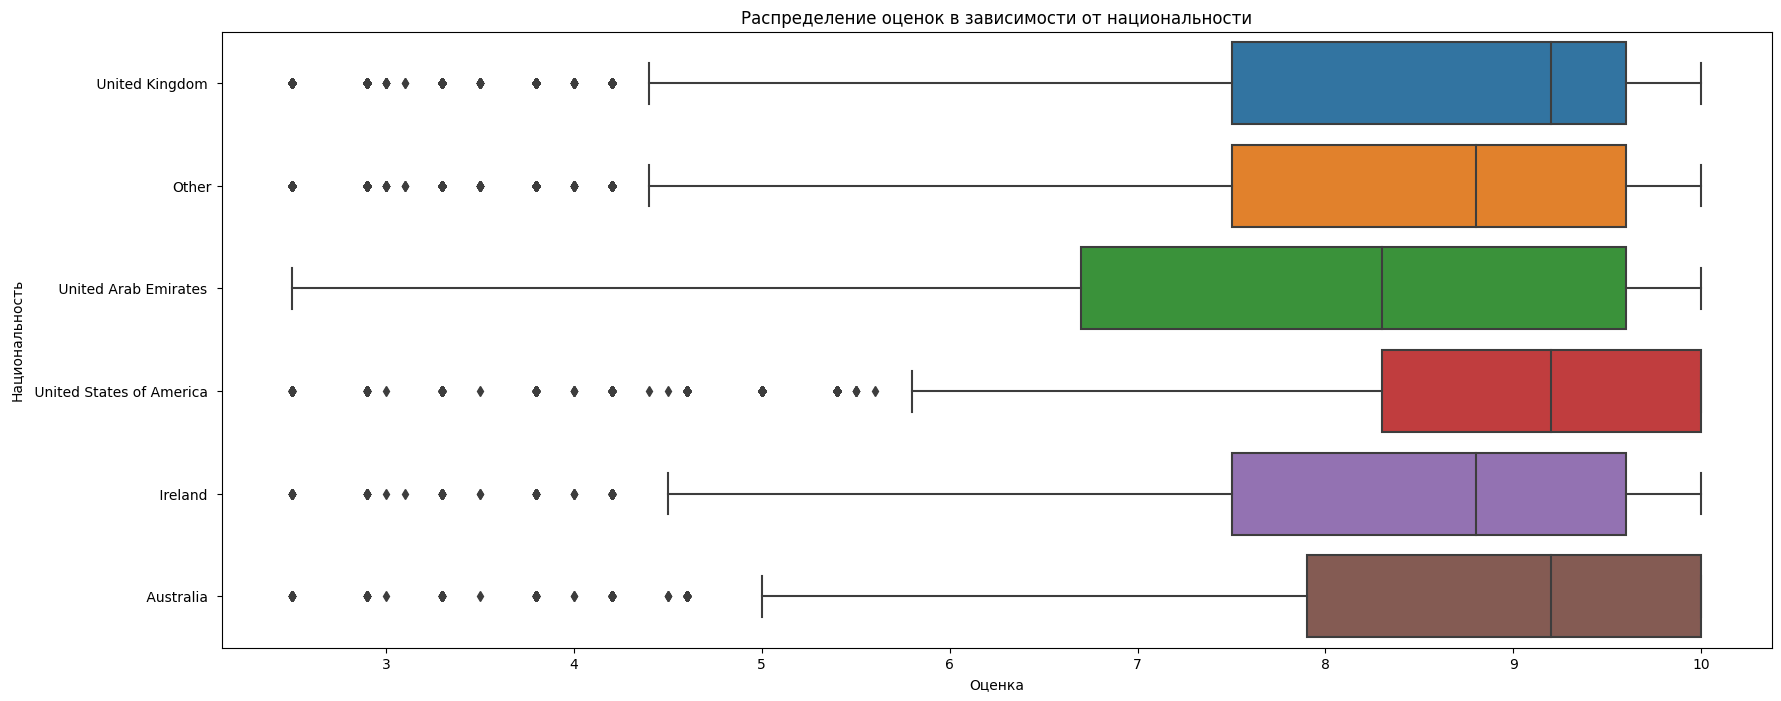

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='reviewer_nationality',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от национальности')
plt.xlabel('Оценка')
plt.ylabel('Национальность')
plt.show()

## Теги

In [ ]:
data['tags'].head(5)

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

In [ ]:
# Создаем функцию извлечения тега
def extract_tags(tags_string):
    return list(tag.strip(" '[]") for tag in tags_string.split(','))

# Применяем функцию к столбцу 'tags' и обновляем список тегов
data['tags'] = data['tags'].apply(lambda x: extract_tags(x))

data['tags'].head(5)

0    [Leisure trip, Couple, Double Room, Stayed 2 n...
1    [Leisure trip, Group, Triple Room, Stayed 1 ni...
2    [Business trip, Solo traveler, Twin Room, Stay...
3    [Leisure trip, Couple, Ambassador Junior Suite...
4    [Business trip, Solo traveler, Classic Double ...
Name: tags, dtype: object

In [ ]:
data['tags'].explode().value_counts().nlargest(15)

tags
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Name: count, dtype: int64

In [ ]:
data['tags'].apply(lambda x: len(x)).max()

6

Всего максимальное количество тегов к проживанию 6, т.е. 6 типов. Чтобы найти все возможные значения для каждого типа тега пройдемся по датафрему с полными шестью тегами:

In [ ]:
tags_6_length = data[data['tags'].apply(lambda x: len(x)) == 6]['tags']
tags_6_length.sample(5)

28030     [With a pet, Business trip, Couple, Standard D...
214978    [With a pet, Leisure trip, Family with young c...
465050    [With a pet, Leisure trip, Couple, Double or T...
236690    [With a pet, Leisure trip, Group, Standard Roo...
464945    [With a pet, Leisure trip, Family with young c...
Name: tags, dtype: object

In [ ]:
# Списки для создания тегов по каждому типу
with_a_pet = []
trip_type = []
travelers = []
room_type = []
nights_stayed = []
device_used = []

# Получаем уникальные значения для каждой позиции в списке тегов
unique_tags_by_position = [set([tags[i] for tags in tags_6_length]) for i in range(6)]

# Выводим уникальные значения для каждой позиции
for i, unique_tags in enumerate(unique_tags_by_position):
    print(f"Уникальные значения для позиции {i+1}:")
    print(unique_tags)
    if i == 0:
        with_a_pet.extend(list(unique_tags))
    elif i == 1:
        trip_type.extend(list(unique_tags))
    elif i == 2:
        travelers.extend(list(unique_tags))
    elif i == 3:
        room_type.extend(list(unique_tags))
    elif i == 4:
        nights_stayed.extend(list(unique_tags))
    elif i == 5:
        device_used.extend(list(unique_tags))

    print()

Уникальные значения для позиции 1:
{'With a pet'}

Уникальные значения для позиции 2:
{'Leisure trip', 'Business trip'}

Уникальные значения для позиции 3:
{'Solo traveler', 'Couple', 'Group', 'Family with older children', 'Family with young children'}

Уникальные значения для позиции 4:
{'Premium King Room', 'Marina Double Suite', 'Single Room', 'Classic Room with Courtyard View', 'Family Room with King Bed and Sofa Bed', 'Deluxe Double Room', 'Standard Double Room without Window', 'Standard Room with Queen Bed Renovated', 'Double Room with Free Airport Shuttle Service from 5 00am to 00 30am', 'Double Room with Single Bed', 'Luxury Double Room Mezzanine', 'Classic Suite', 'Junior Triple Suite', 'Standard Double Room with Sofa Bed 3 Adults', 'Small Single Room', 'Nhow Double or Twin Room', 'Premier King Room', 'Premium Superior Double Room', 'Superior Double Room with Balcony and City View', 'Superior Room with 1 Double Bed and 1 Sofa Bed 1 place', 'Double Room with Two Double Beds', '

In [ ]:
other = []
all_tags = set(tag for tags in data['tags'] for tag in tags)
for tag in all_tags:
    if tag in with_a_pet or tag in trip_type or tag in travelers or tag in room_type or tag in nights_stayed or tag in device_used:
        pass
    elif tag.startswith('Stayed'):
        nights_stayed.append(tag)
    else:
        other.append(tag)

Чтобы не пропустить какие-либо уникальные значения для каждого типа тега, мы пройдемся по первым тегам всего датасета. В общей массе тегов типов комнат трудно их заметить, но первые теги именно это и представляют.

In [ ]:
unique_tags_1 = set([tags[0] for tags in data['tags'] if len(tags) >= 1 for tag in tags])
print(unique_tags_1)

{'Leisure trip', 'Business trip', 'Couple', 'Solo traveler', 'Travelers with friends', 'Group', 'Family with older children', 'With a pet', 'Family with young children'}


In [ ]:
travelers.append('Travelers with friends')
other.remove('Travelers with friends')
room_type.extend(other)

In [ ]:
print(len(room_type))
print(with_a_pet)
print(trip_type)
print(travelers)
print(nights_stayed)
print(device_used)

2387
['With a pet']
['Leisure trip', 'Business trip']
['Solo traveler', 'Couple', 'Group', 'Family with older children', 'Family with young children', 'Travelers with friends']
['Stayed 20 nights', 'Stayed 11 nights', 'Stayed 2 nights', 'Stayed 7 nights', 'Stayed 14 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Stayed 10 nights', 'Stayed 18 nights', 'Stayed 9 nights', 'Stayed 3 nights', 'Stayed 8 nights', 'Stayed 1 night', 'Stayed 6 nights', 'Stayed 25 nights', 'Stayed 29 nights', 'Stayed 26 nights', 'Stayed 24 nights', 'Stayed 27 nights', 'Stayed 16 nights', 'Stayed 13 nights', 'Stayed 22 nights', 'Stayed 30 nights', 'Stayed 12 nights', 'Stayed 31 nights', 'Stayed 23 nights', 'Stayed 15 nights', 'Stayed 17 nights', 'Stayed 19 nights', 'Stayed 28 nights', 'Stayed 21 nights']
['Submitted from a mobile device']


In [ ]:
print(len(room_type))
print(with_a_pet)
print(trip_type)
print(travelers)
print(nights_stayed)
print(device_used)

2387
['With a pet']
['Leisure trip', 'Business trip']
['Solo traveler', 'Couple', 'Group', 'Family with older children', 'Family with young children', 'Travelers with friends']
['Stayed 20 nights', 'Stayed 11 nights', 'Stayed 2 nights', 'Stayed 7 nights', 'Stayed 14 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Stayed 10 nights', 'Stayed 18 nights', 'Stayed 9 nights', 'Stayed 3 nights', 'Stayed 8 nights', 'Stayed 1 night', 'Stayed 6 nights', 'Stayed 25 nights', 'Stayed 29 nights', 'Stayed 26 nights', 'Stayed 24 nights', 'Stayed 27 nights', 'Stayed 16 nights', 'Stayed 13 nights', 'Stayed 22 nights', 'Stayed 30 nights', 'Stayed 12 nights', 'Stayed 31 nights', 'Stayed 23 nights', 'Stayed 15 nights', 'Stayed 17 nights', 'Stayed 19 nights', 'Stayed 28 nights', 'Stayed 21 nights']
['Submitted from a mobile device']


In [ ]:
data['tags']

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

In [ ]:
#Функция кодирования тега проживания с животным
def pets_tag(row):
    if 'With a pet' in row:
        row.remove('With a pet')
        return 1
    else:
        return 0

data['tag_pets'] = data['tags'].apply(pets_tag)

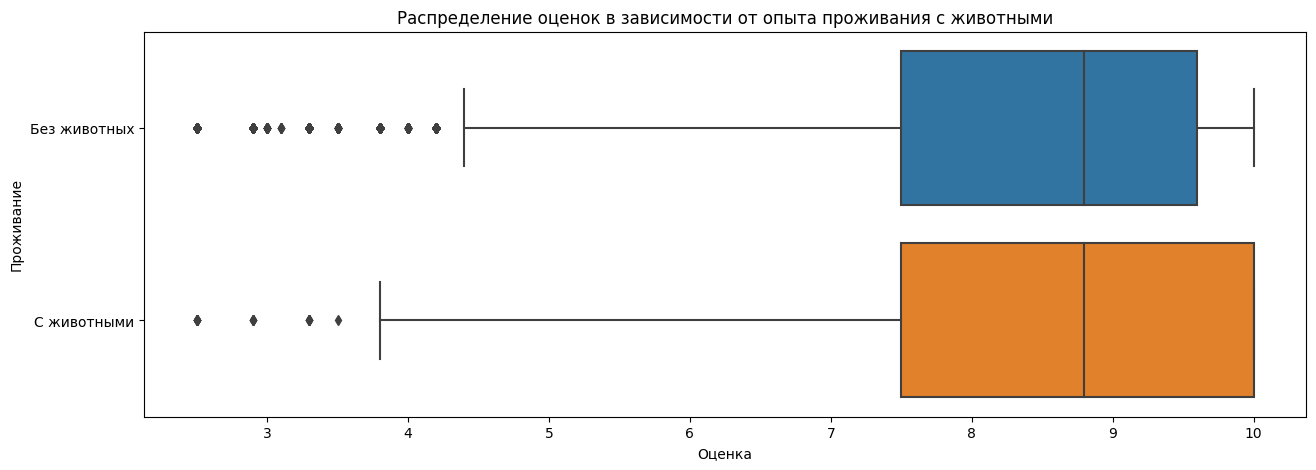

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='tag_pets',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от опыта проживания с животными')
plt.xlabel('Оценка')
plt.ylabel('Проживание')
plt.yticks([0, 1], ['Без животных', 'С животными'])
plt.show()

Средняя оценка не меняется и думаю этот признак не особо полезен в прогнозировании.

In [ ]:
#Функция кодирования тега отправлено с мобильного устройства
def device(row):
    if 'Submitted from a mobile device' in row:
        row.remove('Submitted from a mobile device')
        return 1
    else:
        return 0

data['tag_mobile_device'] = data['tags'].apply(device)

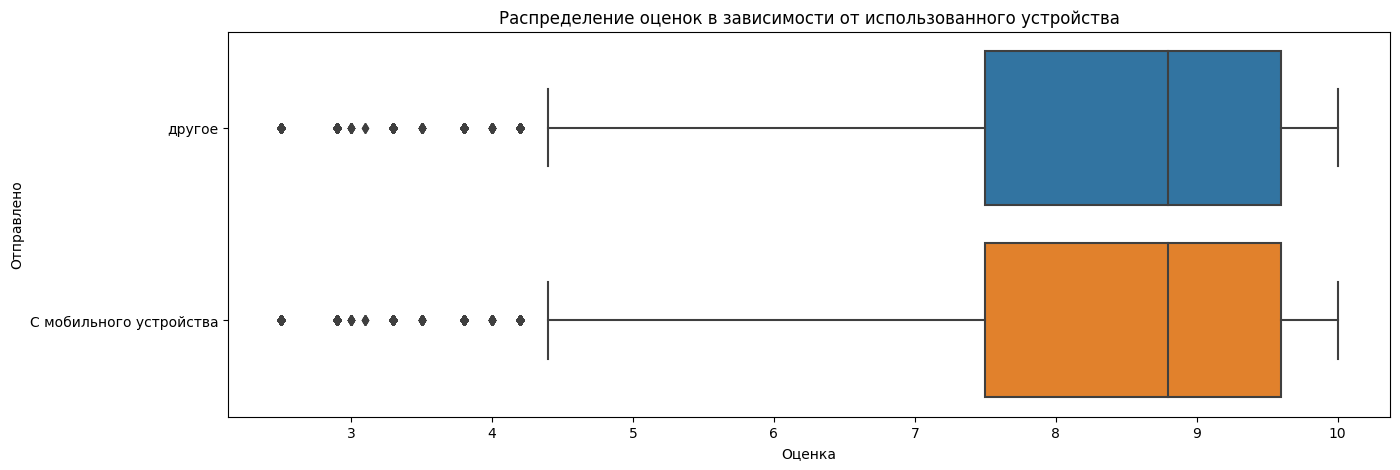

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='tag_mobile_device',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от использованного устройства')
plt.xlabel('Оценка')
plt.ylabel('Отправлено')
plt.yticks([0, 1], ['другое', 'С мобильного устройства'])
plt.show()

Не совсем понимаю этот тег, показатель, что отзыв был отправлен с мобильного устройства. Думаю он тоже бесполезен.

In [ ]:
#Функция определения тега Рабочая поездка или Отдых
def type_trip_tag(row):
    if 'Leisure trip' in row:
        row.remove('Leisure trip')
        return 'Leisure trip'
    elif 'Business trip' in row:
        row.remove('Business trip')
        return 'Business trip'
    else:
        return None
    
data['tag_type_trip'] = data['tags'].apply(type_trip_tag)

In [ ]:
data['tag_type_trip'].value_counts()

tag_type_trip
Leisure trip     417778
Business trip     82939
Name: count, dtype: int64

Большинство отзывов с отдыха, нежели с рабочей поездки. Люди путешествующие по работе ставят в среднем оценку ниже, чем на отдыхе. Скорее всего они могут испытывать больший уровень стресса из-за работы, сроков и обязательств, что может повлиять на их восприятие и удовлетворенность услугами отеля. А также в отличие от отпуска, когда люди могут расслабиться и провести время так, как им нравится, на рабочих поездках времени на отдых может быть недостаточно. Это может привести к чувству усталости и раздражения, что отразится на оценке услуг отеля. Думаю это полезный показатель для обучения.

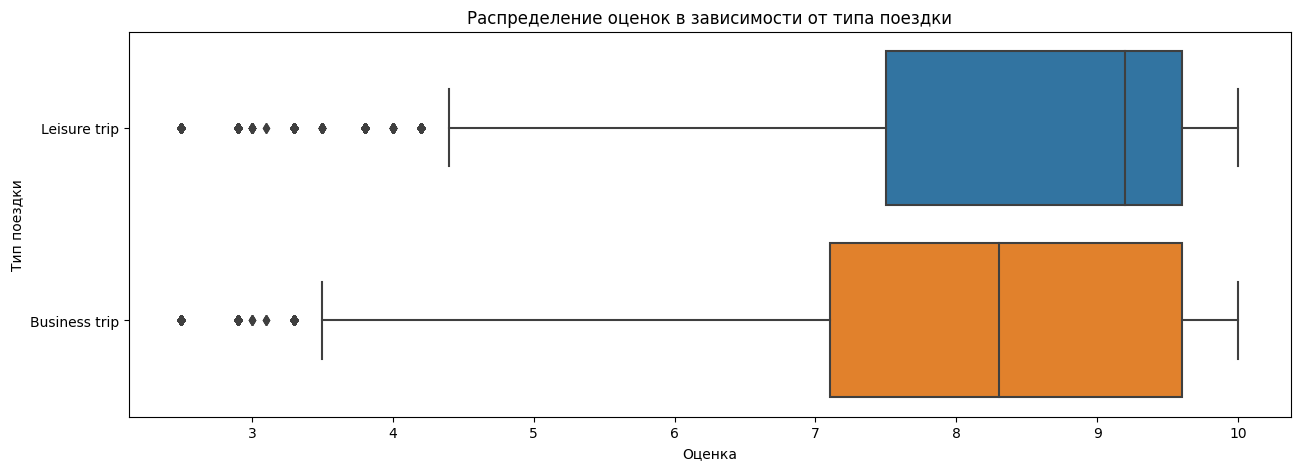

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='tag_type_trip',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от типа поездки')
plt.xlabel('Оценка')
plt.ylabel('Тип поездки')
plt.show()

In [ ]:
data['tag_type_trip'].isnull().sum()

15021

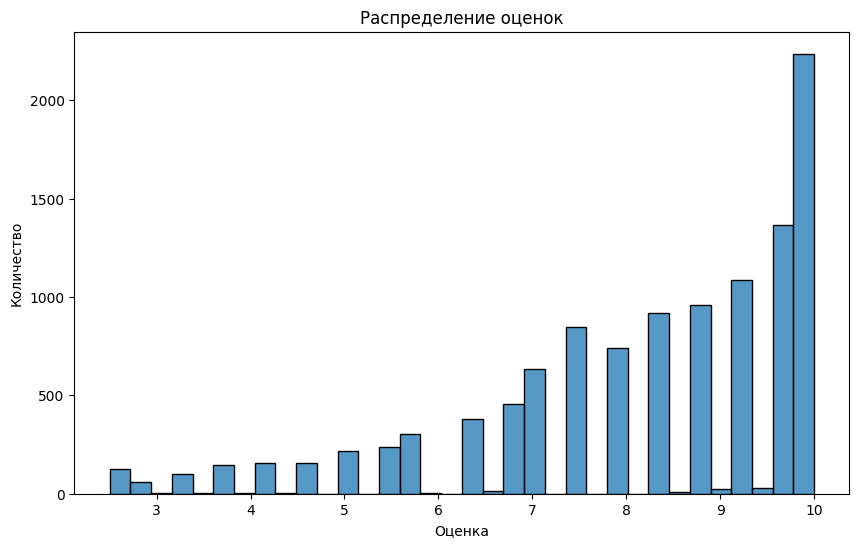

In [ ]:
mask_null_type = data['tag_type_trip'].isnull()
plt.figure(figsize=(10, 6))
sns.histplot(data=data[(data['sample'] == 1) & mask_null_type], x='reviewer_score')

plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()

Для 15021 строк нет записи о типе поездки. Заменим их наиболее встречающимся Leisure trip 

In [ ]:
data['tag_type_trip'] = data['tag_type_trip'].fillna('Leisure trip')

In [ ]:
#Функция определения тега тип туристов:
def type_travelers(row):
    if 'Group' in row:
        row.remove('Group')
        return 'Group'
    elif 'Family with young children' in row:
        row.remove('Family with young children')
        return 'Family with young children'
    elif 'Solo traveler' in row:
        row.remove('Solo traveler')
        return 'Solo traveler'
    elif 'Couple' in row:
        row.remove('Couple')
        return 'Couple'
    elif 'Family with older children' in row:
        row.remove('Family with older children')
        return 'Family with older children'
    elif 'Travelers with friends' in row:
        row.remove('Travelers with friends')
        return 'Travelers with friends'
    else:
        return None
    
data['tag_travelers'] = data['tags'].apply(type_travelers)

In [ ]:
data['tag_travelers'].isnull().sum() #пропущенных значений о типе туристов нет

0

In [ ]:
#Функция определения тега количества ночей:
def night_stayed(row):
    for tag in row:
        if tag.startswith('Stayed'):
            count_nights = int(tag.split()[1])
            row.remove(tag)
            return count_nights
    return None

data['tag_nights_stayed'] = data['tags'].apply(night_stayed)

In [ ]:
data['tag_nights_stayed'].value_counts()

tag_nights_stayed
1.0     193645
2.0     133937
3.0      95821
4.0      47817
5.0      20845
6.0       9776
7.0       7399
8.0       2502
9.0       1293
10.0       889
11.0       418
12.0       316
14.0       247
13.0       246
15.0       117
16.0        57
17.0        42
18.0        33
19.0        29
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: count, dtype: int64

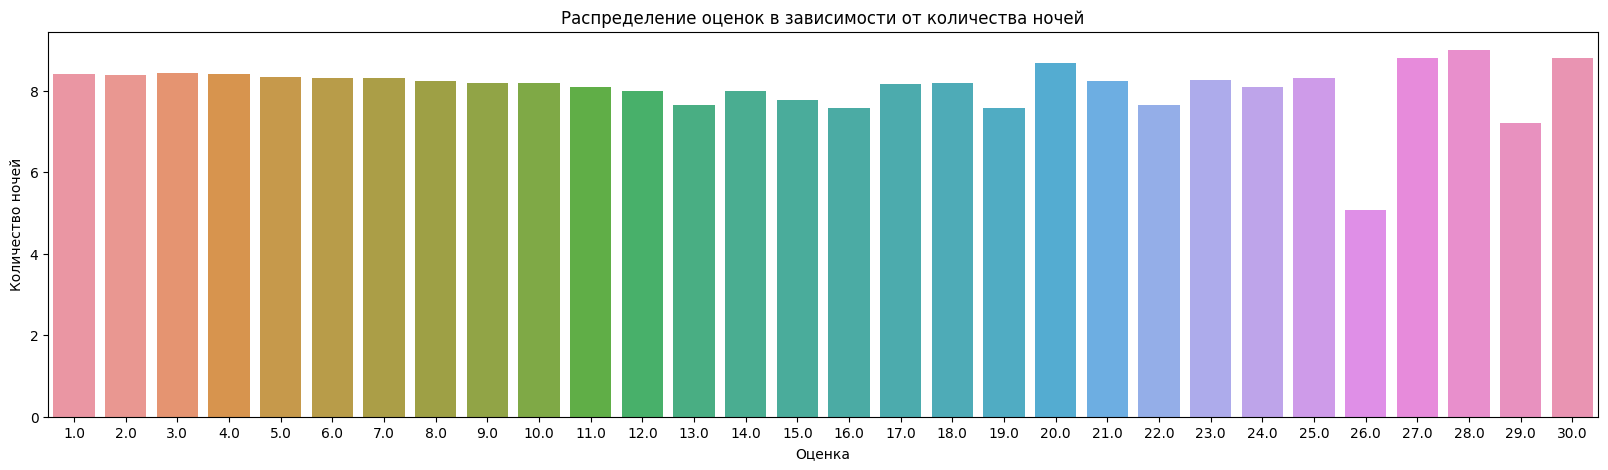

In [ ]:
fig_nights = data[data['sample'] == 1].groupby('tag_nights_stayed')['reviewer_score'].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(data=fig_nights, x='tag_nights_stayed', y='reviewer_score')
plt.title('Распределение оценок в зависимости от количества ночей')
plt.xlabel('Оценка')
plt.ylabel('Количество ночей')
plt.show()

Люди чаще всего останавливаются на 1-5 ночей, потому что в датасете представлены столицы городов, а не курортные города, куда люди приезжают на длительный отдых. С прибавлением срока пребыввания в городе, чаще появляются низкие оценки. Туристы успевают заметить недостатки за это время и отражают это в отзывах.

In [ ]:
data['tag_nights_stayed'].isnull().sum()

192

Для 192 записи пропущена длительность пребывания. Посмотрим на распределение оценок для этих записей

In [ ]:
mask_null_nights = data['tag_nights_stayed'].isnull()

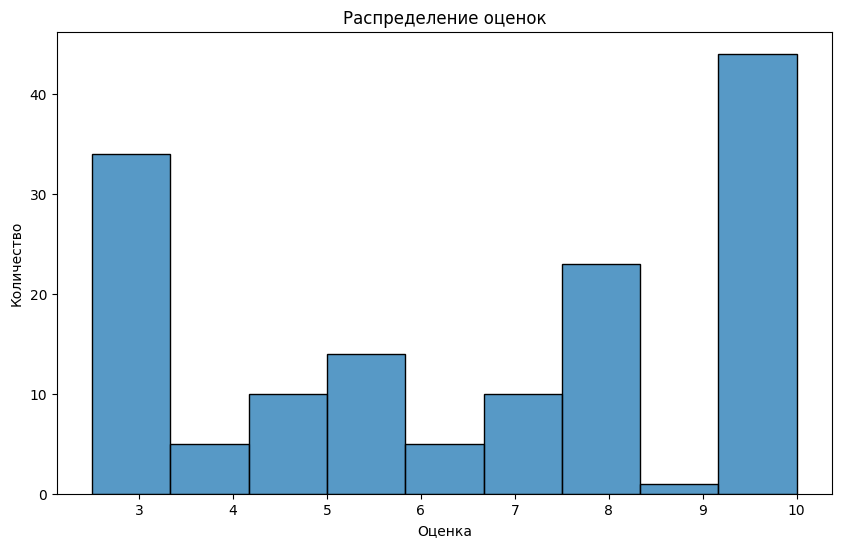

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data[(data['sample'] == 1) & mask_null_nights], x='reviewer_score')

plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()

В списках остались только теги, обозначающие тип комнат, выделим их и посмотрим есть ли пропущенные значения:

In [ ]:
data['tags'] = data['tags'].explode()
print(data['tags'].isnull().sum())
mask_null_room = data['tags'].isnull()

192


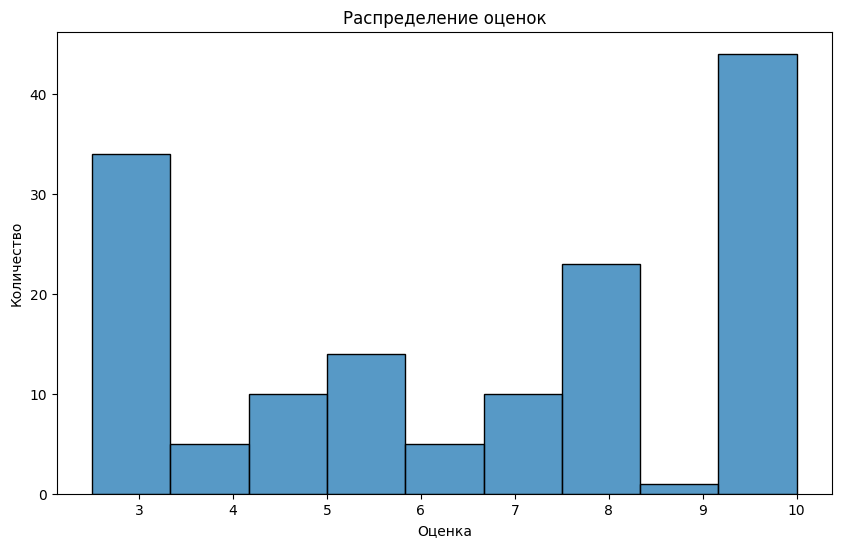

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data[(data['sample'] == 1) & mask_null_room], x='reviewer_score')

plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()

In [ ]:
data[['tags', 'tag_nights_stayed']][mask_null_nights & mask_null_room].shape[0]

192

Пропущенных тегов о типе комнаты совпадают с пропущенными значениями количества ночей. Возможно был какой-то сбой при выгрузке тегов и количество ночей вместе с типом комнат не были выгружены. Думаю можно заполнить эти пропуски средним значением. А тип комнат закодировать пятью самыми популярными.

In [ ]:
data['tag_nights_stayed'].fillna(round(data['tag_nights_stayed'].mean()), inplace=True)

Выделим 5 самых популярных типов комнат:

In [ ]:
data['tags'].value_counts().nlargest(10)

tags
Double Room                     35207
Standard Double Room            32248
Superior Double Room            31393
Deluxe Double Room              24823
Double or Twin Room             22393
Standard Double or Twin Room    17483
Classic Double Room             16989
Superior Double or Twin Room    13570
2 rooms                         12393
Standard Twin Room               9745
Name: count, dtype: int64

In [ ]:
def room_type(row):
    important_rooms =['Double Room', 'Standard Double Room', 'Superior Double Room', 'Deluxe Double Room', 'Double or Twin Room']
    if row in important_rooms:
        return row
    elif pd.isna(row):
        return 'Other'
    else:
        return "Other"

In [ ]:
data['tag_room_type'] = data['tags'].apply(room_type)

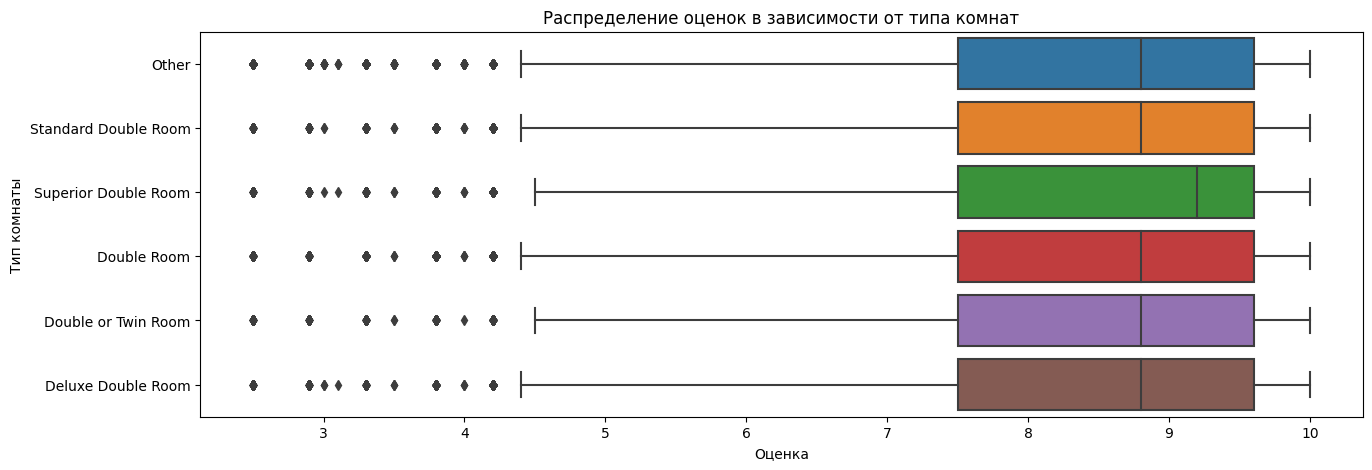

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = data[data['sample'] == 1],
    x='reviewer_score',
    y='tag_room_type',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от типа комнат')
plt.xlabel('Оценка')
plt.ylabel('Тип комнаты')
plt.show()

Выделим колонки для кодирования:

In [ ]:
cat_columns=['reviewer_nationality', 'country', 'tag_type_trip', 'tag_travelers', 'tag_room_type']

In [ ]:
data[cat_columns] = data[cat_columns].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [ ]:
onehot_encoder = OneHotEncoder(cols=cat_columns, use_cat_names=True)
data = onehot_encoder.fit_transform(data)

# Отбор признаков

In [ ]:
# Копия для разных попыток отбора признаков
data_copy2 = data.copy()

Удалим все нечисловые признаки:

In [ ]:
columns_to_drop = ['hotel_address', 'review_date', 'hotel_name', 'negative_review', 'positive_review', 'tags', 'city']

In [ ]:
data.drop(columns_to_drop, inplace=True, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 53 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   reviewer_nationality_ United Kingdom             515738 non-null  int64  
 3   reviewer_nationality_Other                       515738 non-null  int64  
 4   reviewer_nationality_ United States of America   515738 non-null  int64  
 5   reviewer_nationality_ Ireland                    515738 non-null  int64  
 6   reviewer_nationality_ Australia                  515738 non-null  int64  
 7   reviewer_nationality_ United Arab Emirates       515738 non-null  int64  
 8   review_total_negative_word_counts                515738 non-null  int64  
 9   total_number_of

In [ ]:
num_cols = ['additional_number_of_scoring','review_total_negative_word_counts', 'total_number_of_reviews',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given',
            'days_since_review', 'lat', 'lng', 'distance_to_center', 'positive_to_negative_diff',
            'pos_pos_rev', 'pos_neg_rev', 'pos_neu_rev', 'pos_compound_rev',
            'neg_pos_rev', 'neg_neg_rev', 'neg_neu_rev', 'neg_compound_rev', 'tag_nights_stayed']

In [ ]:
cat_cols = ['average_score', 'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_Other',
            'reviewer_nationality_ United Arab Emirates ', 'reviewer_nationality_ United States of America ',
            'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Australia ', 'country_United Kingdom',
            'country_France', 'country_Netherlands', 'country_Italy', 'country_Austria', 'country_Spain',
            'month', 'year', 'quarter', 'tag_pets', 'tag_mobile_device', 'tag_type_trip_Leisure trip',
            'tag_type_trip_Business trip', 'tag_travelers_Couple', 'tag_travelers_Solo traveler',
            'tag_travelers_Family with young children', 'tag_travelers_Group', 'tag_travelers_Family with older children',
            'tag_travelers_Travelers with friends', 'tag_room_type_Other', 'tag_room_type_Standard Double Room',
            'tag_room_type_Superior Double Room', 'tag_room_type_Double Room', 'tag_room_type_Double or Twin Room',
            'tag_room_type_Deluxe Double Room']

Text(0.5, 1.0, 'Корреляция непрерывных признаков')

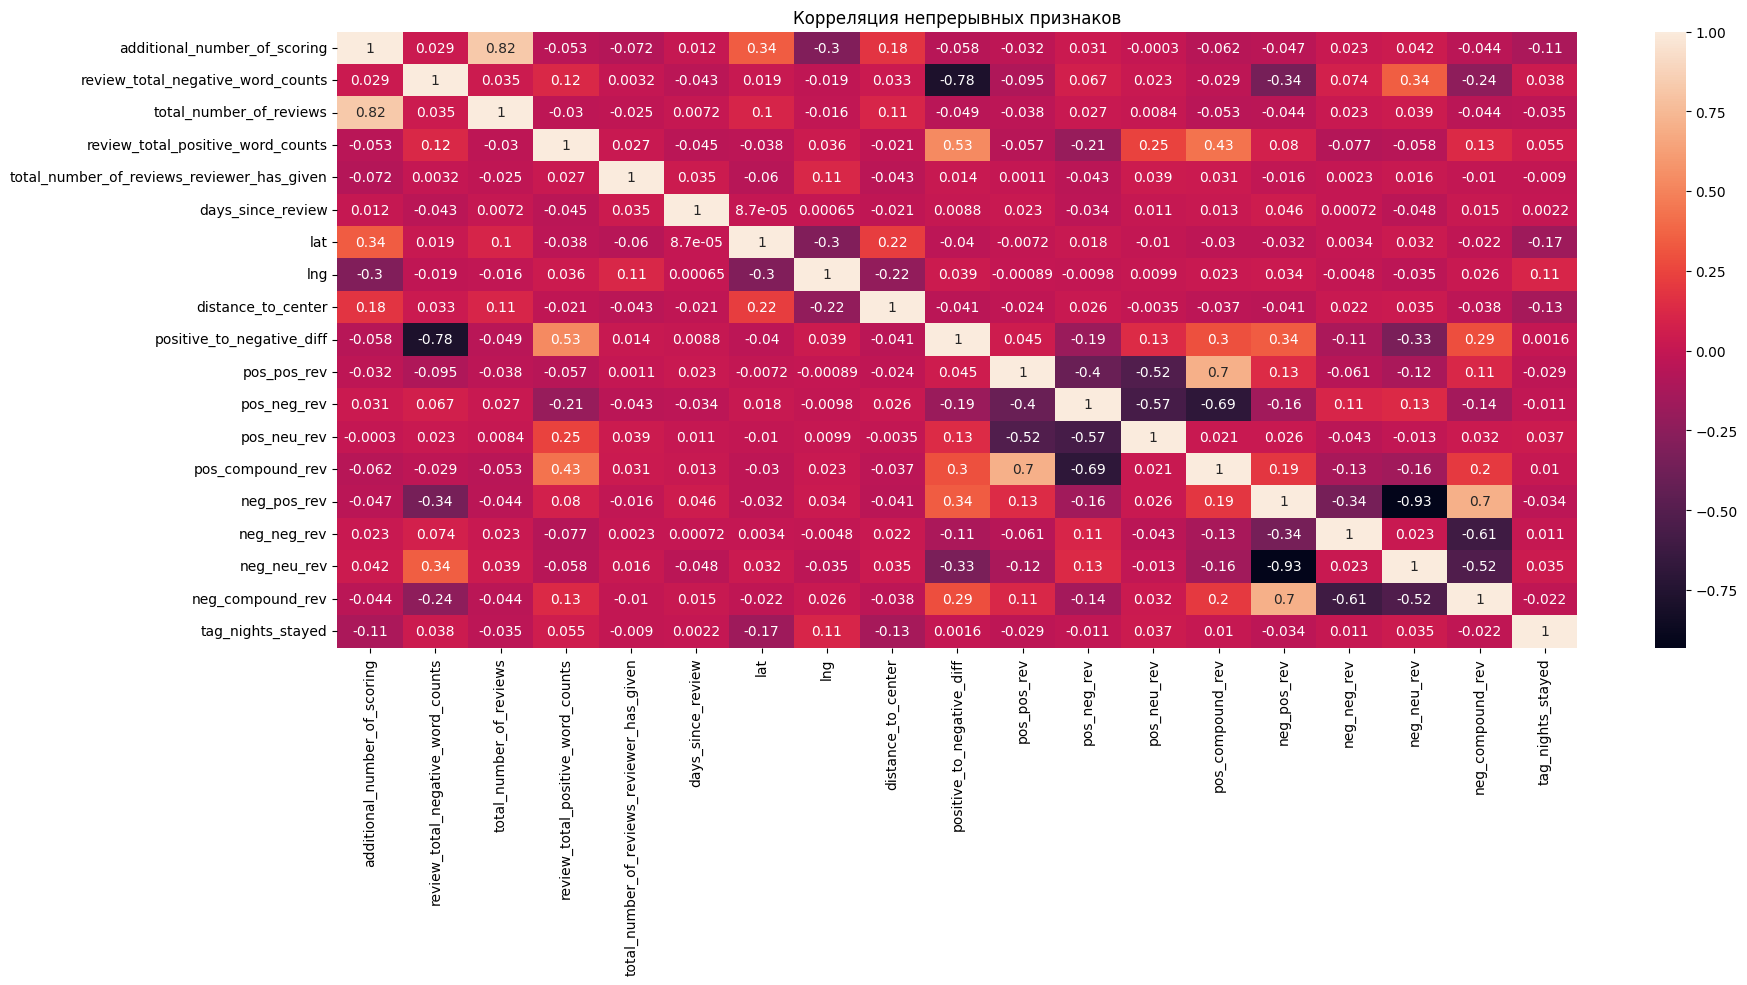

In [ ]:
corr = data[num_cols].corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr, annot=True)
plt.title('Корреляция непрерывных признаков')

Удалим координаты, т.к. не вижу в них особо смысла, останется только признак расстояния до центра. Сильно коррелирующее значение тональности не буду удалять, оценка тональности одна из самых влиятельных на модель

In [ ]:
# Создаем список для удаления
drop_data = ['lat', 'lng']

#Удалим из num_cols
for item in drop_data:
    if item in num_cols:
        num_cols.remove(item)

In [ ]:
data.drop(drop_data, axis=1, inplace=True)

Text(0.5, 1.0, 'Корреляция категориальных признаков')

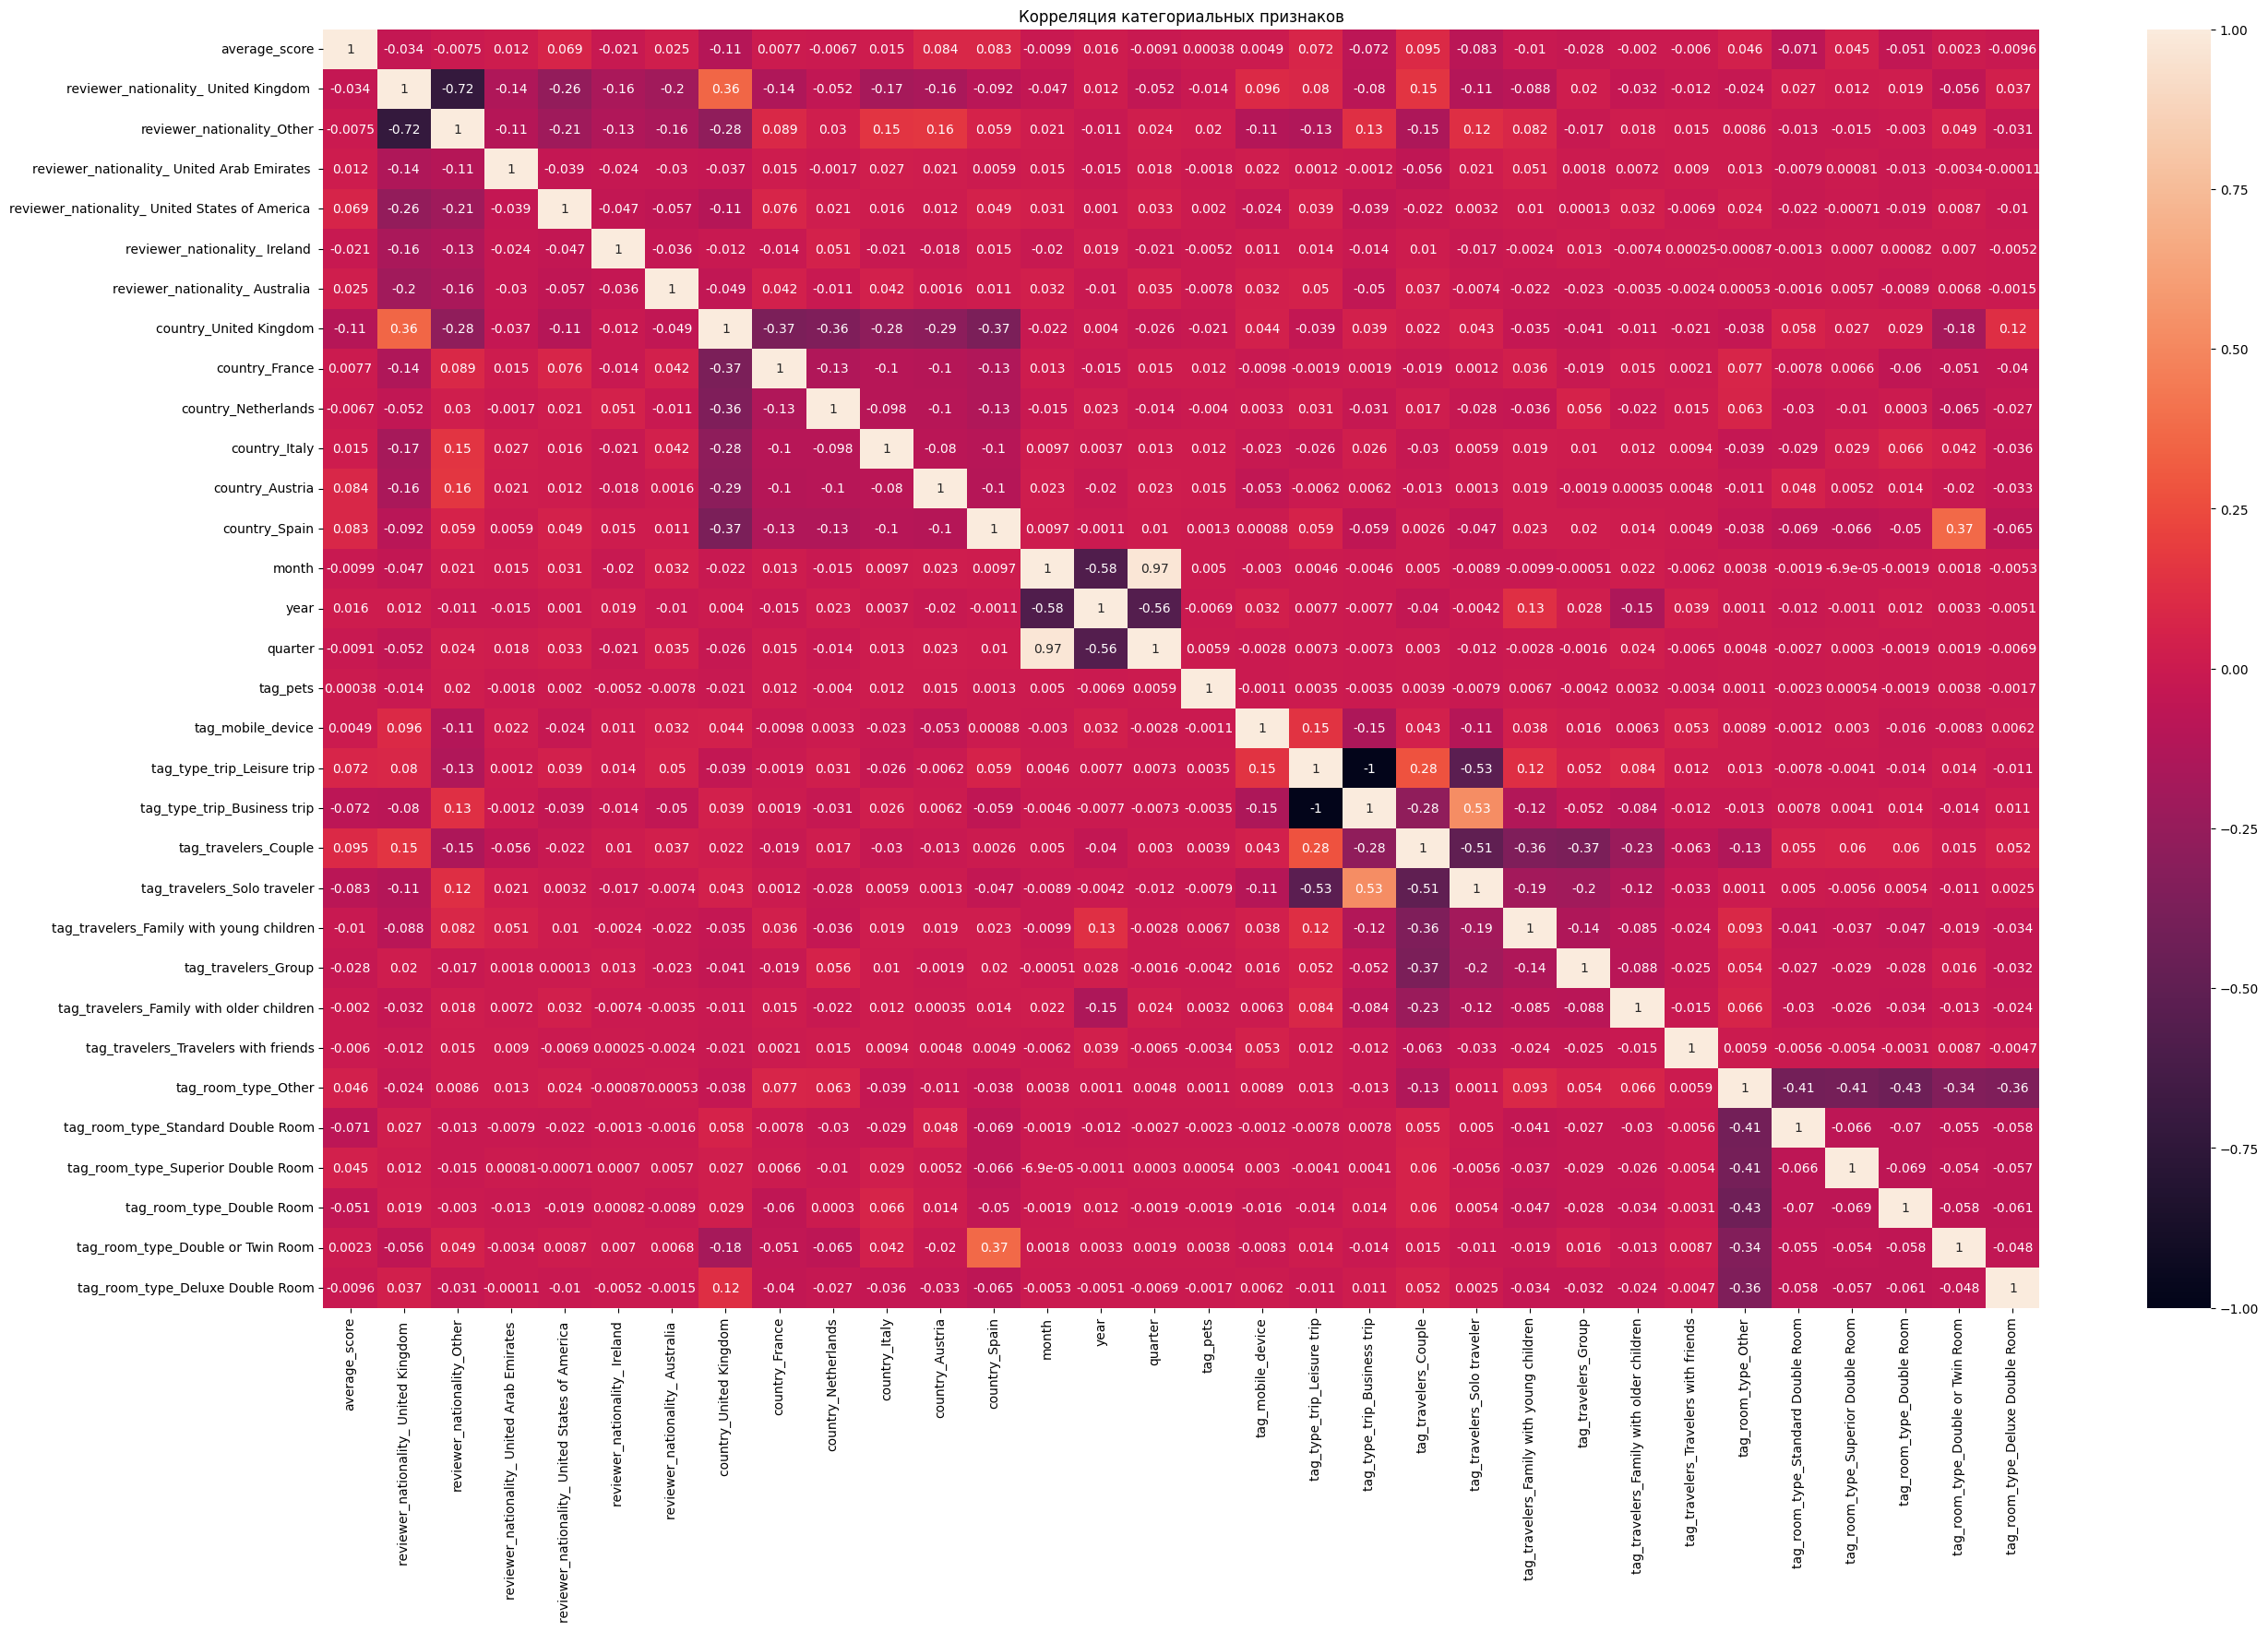

In [ ]:
corr = data[cat_cols].corr()

plt.figure(figsize=(30,18))
sns.heatmap(corr, annot=True)
plt.title('Корреляция категориальных признаков')

Удалим признак тега рабочей поездки, потому что он коррелирует с тегом отдыха. А также удалим месяц и год, потому что они особо не влияют на целевую переменную и коррелирует с кварталом

In [ ]:
drop_data = ['tag_type_trip_Business trip', 'month', 'year']

In [ ]:
#Удалим из cat_cols
for item in drop_data:
    if item in cat_cols:
        cat_cols.remove(item)

In [ ]:
data.drop(drop_data, axis=1, inplace=True)

# Оценка значимости признаков

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   reviewer_nationality_ United Kingdom             515738 non-null  int64  
 3   reviewer_nationality_Other                       515738 non-null  int64  
 4   reviewer_nationality_ United States of America   515738 non-null  int64  
 5   reviewer_nationality_ Ireland                    515738 non-null  int64  
 6   reviewer_nationality_ Australia                  515738 non-null  int64  
 7   reviewer_nationality_ United Arab Emirates       515738 non-null  int64  
 8   review_total_negative_word_counts                515738 non-null  int64  
 9   total_number_of

In [ ]:
# теперь выделим тестовую часть
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
X

,additional_number_of_scoring,average_score,reviewer_nationality_ United Kingdom,reviewer_nationality_Other,reviewer_nationality_ United States of America,reviewer_nationality_ Ireland,reviewer_nationality_ Australia,reviewer_nationality_ United Arab Emirates,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,distance_to_center,quarter,positive_to_negative_diff,neg_pos_rev,neg_neg_rev,neg_neu_rev,neg_compound_rev,pos_pos_rev,pos_neg_rev,pos_neu_rev,pos_compound_rev,tag_pets,tag_mobile_device,tag_type_trip_Leisure trip,tag_travelers_Couple,tag_travelers_Group,tag_travelers_Solo traveler,tag_travelers_Family with young children,tag_travelers_Family with older children,tag_travelers_Travelers with friends,tag_nights_stayed,tag_room_type_Double Room,tag_room_type_Other,tag_room_type_Double or Twin Room,tag_room_type_Superior Double Room,tag_room_type_Standard Double Room,tag_room_type_Deluxe Double Room
128935,581,8.4,1,0,0,0,0,0,3,1994,4,7,531,0,0,0,1,0,0,1.1,1,1,0.0,0.000,1.000,0.0000,0.655,0.000,0.345,0.5859,0,1,1,1,0,0,0,0,0,2.0,0,1,0,0,0,0
128936,299,8.3,1,0,0,0,0,0,3,1361,2,14,203,0,0,0,1,0,0,1.5,1,-1,0.0,0.756,0.244,-0.4767,0.000,0.000,1.000,0.0000,0,0,0,1,0,0,0,0,0,1.0,0,0,0,0,1,0
128937,32,8.9,0,1,0,0,0,0,6,406,0,14,289,0,0,0,0,1,0,1.9,4,-6,0.0,0.423,0.577,-0.2960,0.000,1.000,0.000,-0.5719,0,1,1,0,0,1,0,0,0,3.0,0,1,0,0,0,0
128938,34,7.5,1,0,0,0,0,0,0,607,11,8,681,0,0,0,0,1,0,5.2,3,11,1.0,0.000,0.000,0.5574,0.721,0.000,0.279,0.9169,0,0,1,0,0,1,0,0,0,1.0,0,1,0,0,0,0
128939,914,8.5,0,1,0,0,0,0,4,7586,20,10,516,0,1,0,0,0,0,3.4,1,16,0.0,0.667,0.333,-0.2500,0.382,0.000,0.618,0.8503,0,0,0,1,0,0,0,0,0,6.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,107,9.0,0,1,0,0,0,0,0,617,10,10,106,0,0,0,1,0,0,4.6,2,10,1.0,0.000,0.000,0.5574,0.000,0.000,1.000,0.0000,0,1,1,0,1,0,0,0,0,2.0,0,1,0,0,0,0
515734,272,8.4,0,1,0,0,0,0,0,3224,93,1,171,0,0,0,0,0,1,2.7,1,93,1.0,0.000,0.000,0.5574,0.098,0.045,0.857,0.7264,0,1,1,1,0,0,0,0,0,4.0,0,0,0,0,1,0
515735,457,6.8,0,1,0,0,0,0,12,2751,9,21,543,0,0,0,1,0,0,1.5,1,-3,0.0,0.000,1.000,0.0000,0.535,0.000,0.465,0.7845,0,0,0,0,0,1,0,0,0,1.0,0,1,0,0,0,0
515736,365,8.1,0,0,0,0,0,1,0,1567,6,28,74,0,0,0,1,0,0,2.4,2,6,1.0,0.000,0.000,0.5574,0.000,0.000,1.000,0.0000,0,0,1,0,0,1,0,0,0,2.0,0,0,0,0,0,1


Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

<Axes: >

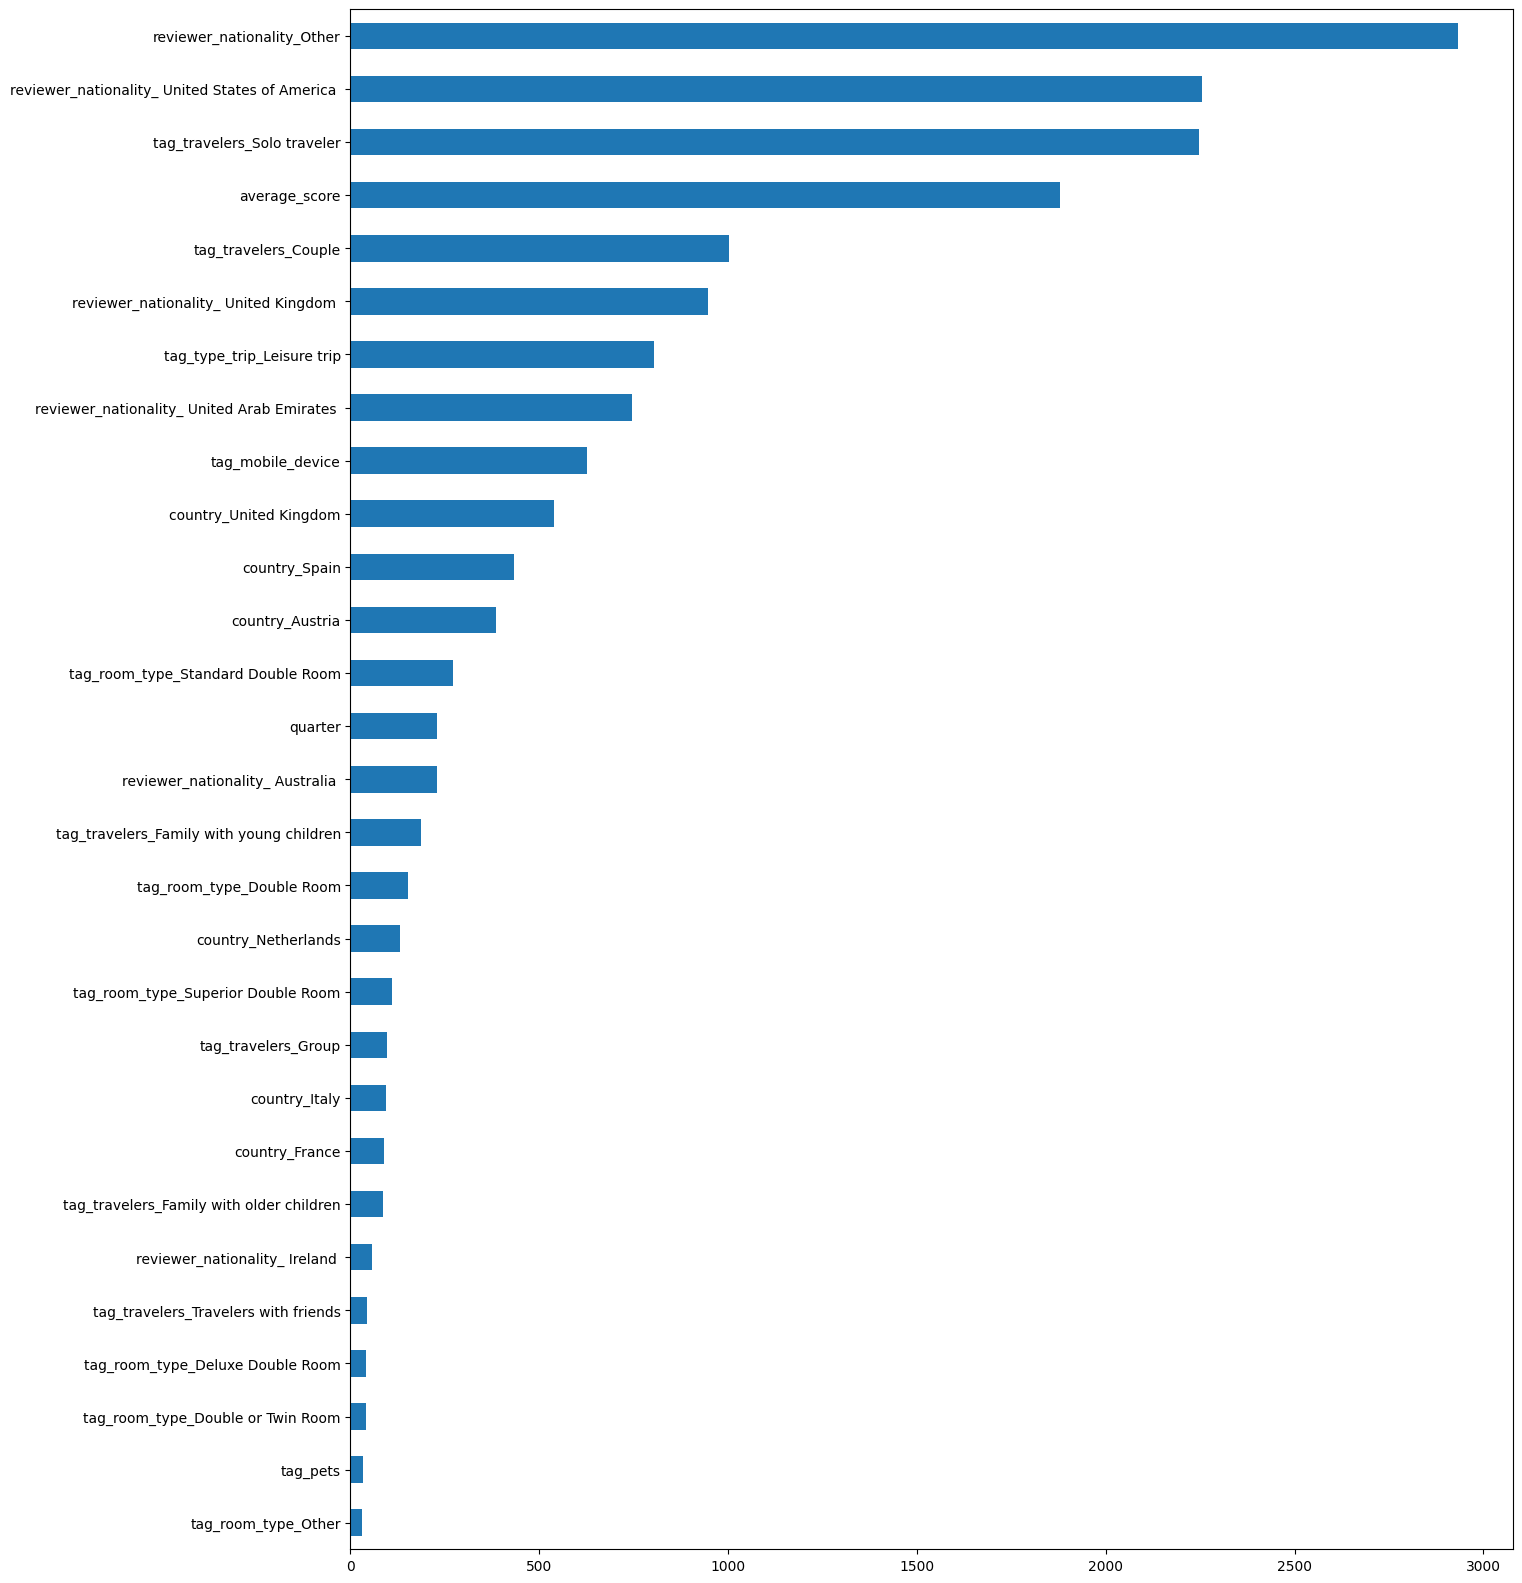

In [ ]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(15, 20))
imp_cat.plot(kind = 'barh')

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит изученный вами в юнитах по статистике анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<Axes: >

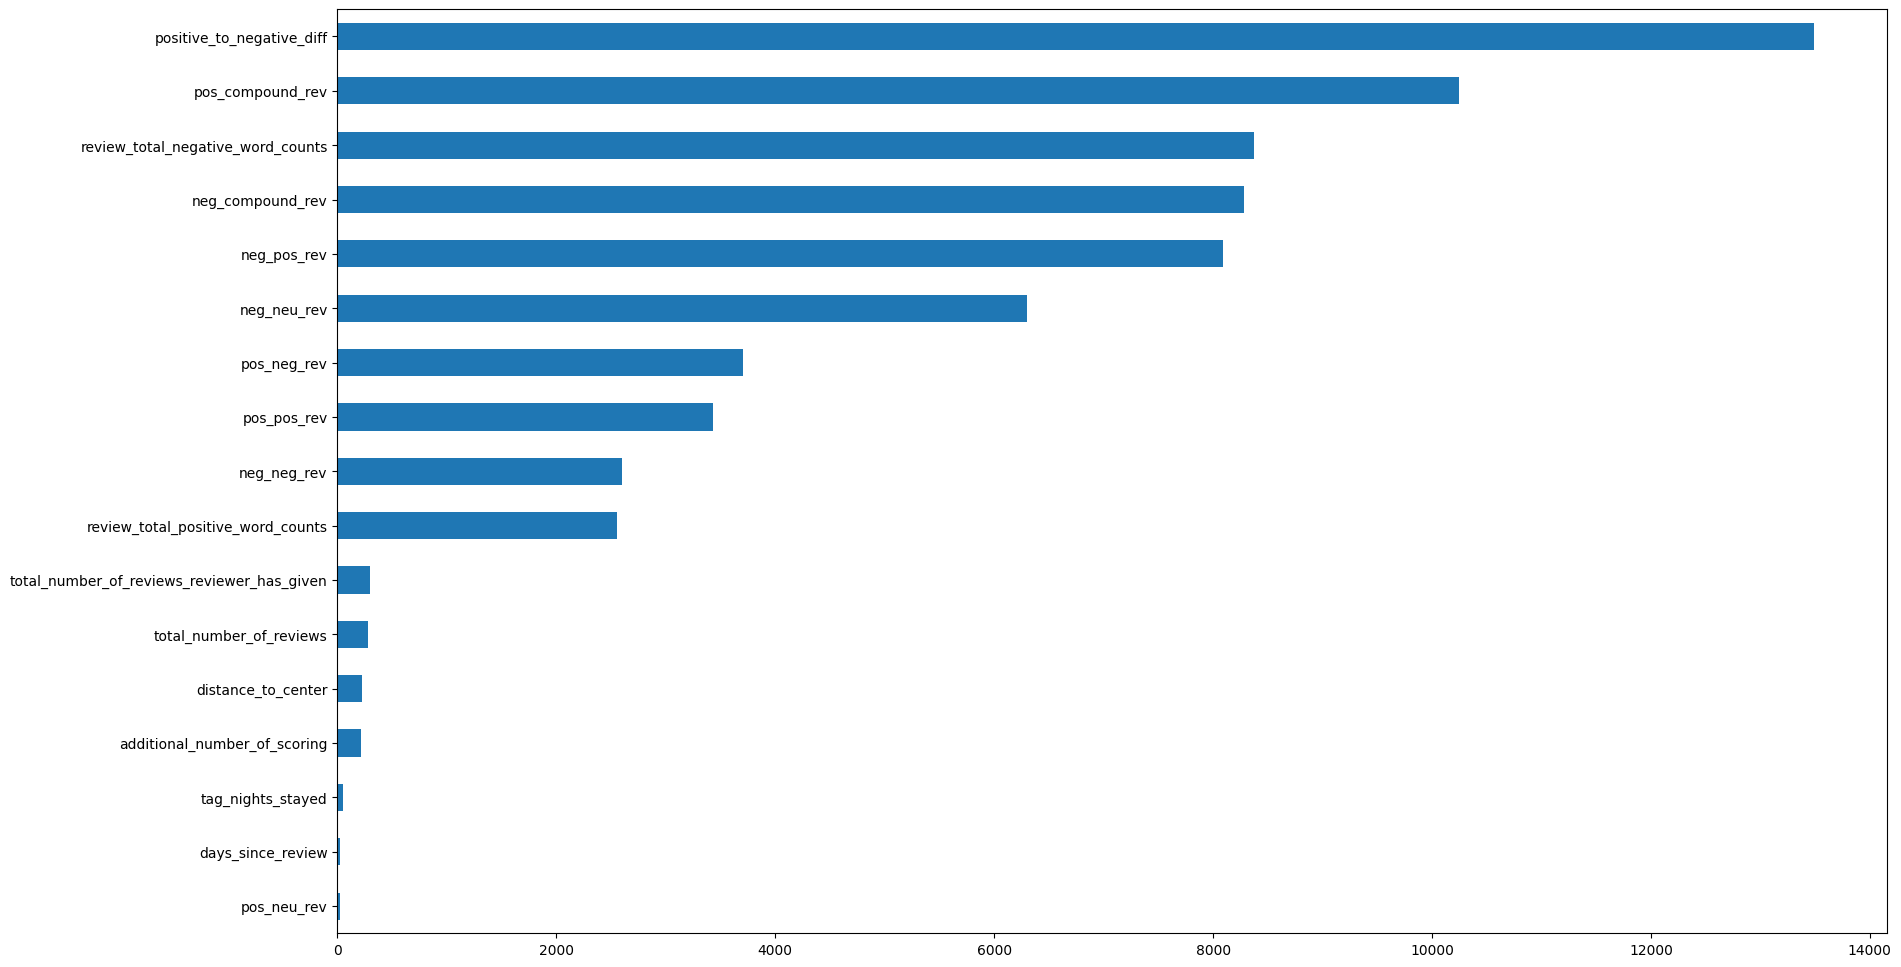

In [ ]:
from sklearn.feature_selection import f_classif # anova
plt.figure(figsize=(20,12))
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 47), (386803, 47), (386803, 46), (309442, 46), (77361, 46))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [ ]:
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 14.9


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.148952355740752


<Axes: >

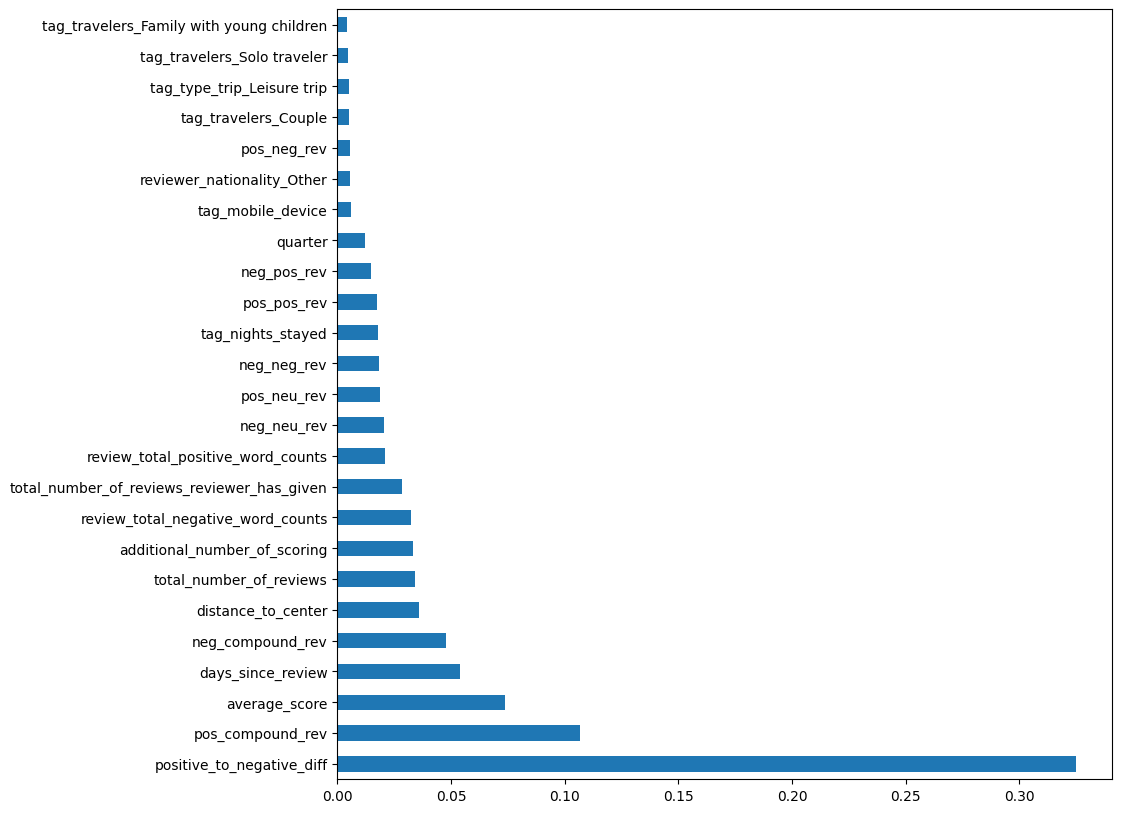

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [ ]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality_ United Kingdom,reviewer_nationality_Other,reviewer_nationality_ United States of America,reviewer_nationality_ Ireland,reviewer_nationality_ Australia,reviewer_nationality_ United Arab Emirates,review_total_negative_word_counts,total_number_of_reviews,...,tag_travelers_Family with young children,tag_travelers_Family with older children,tag_travelers_Travelers with friends,tag_nights_stayed,tag_room_type_Double Room,tag_room_type_Other,tag_room_type_Double or Twin Room,tag_room_type_Superior Double Room,tag_room_type_Standard Double Room,tag_room_type_Deluxe Double Room
60873,260,8.0,0,1,0,0,0,0,59,3461,...,0,0,0,1.0,0,1,0,0,0,0
12852,950,8.6,1,0,0,0,0,0,0,3486,...,0,0,0,1.0,1,0,0,0,0,0
3586,301,8.4,0,0,0,0,0,1,0,3445,...,0,0,0,1.0,0,1,0,0,0,0
53770,415,8.4,0,1,0,0,0,0,35,3340,...,0,0,0,7.0,0,1,0,0,0,0
33146,524,8.2,1,0,0,0,0,0,21,2516,...,0,0,0,1.0,0,1,0,0,0,0
49634,140,7.4,1,0,0,0,0,0,41,895,...,0,1,0,2.0,0,1,0,0,0,0
120608,114,8.7,1,0,0,0,0,0,25,602,...,0,0,0,1.0,0,1,0,0,0,0
7021,556,8.0,1,0,0,0,0,0,0,2347,...,0,0,0,1.0,0,0,0,0,1,0
48484,192,8.4,0,1,0,0,0,0,96,1769,...,0,0,0,3.0,0,1,0,0,0,0
33430,362,8.1,0,1,0,0,0,0,0,1294,...,1,0,0,3.0,0,1,0,0,0,0


In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


In [ ]:
predict_submission

array([8.02, 6.69, 7.85, ..., 7.46, 9.17, 6.97])

In [ ]:
list(sample_submission)

['reviewer_score', 'id']

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.02,488440
1,6.69,274649
2,7.85,374688
3,9.51,404352
4,9.10,451596
5,8.77,302161
6,7.56,317079
7,7.10,13963
8,7.89,159785
9,6.60,195089


Вывод: Удалось получить MAPE - 12.51 посредством EDA. Самый главный признак датасета - сам текст отзыва. Большое влияние на модель оказывают созданные признаки оценки тональности текста.
Нормализация признаков не влияла на итоговый MAPE, хотя данные имели разный масштаб, а удаление незначительных признаков немного ухудшало результат. 
Возможно, чтобы улучшить результат, нужно порботать с выбросами (низкие оценки с большим по количеству слов в положительном отзыве), создать еще новые признаки из текста отзывов.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   reviewer_nationality_ United Kingdom             515738 non-null  int64  
 3   reviewer_nationality_Other                       515738 non-null  int64  
 4   reviewer_nationality_ United States of America   515738 non-null  int64  
 5   reviewer_nationality_ Ireland                    515738 non-null  int64  
 6   reviewer_nationality_ Australia                  515738 non-null  int64  
 7   reviewer_nationality_ United Arab Emirates       515738 non-null  int64  
 8   review_total_negative_word_counts                515738 non-null  int64  
 9   total_number_of

In [ ]:
pd.set_option('display.max_info_rows', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [ ]:
data.describe()

,additional_number_of_scoring,average_score,reviewer_nationality_ United Kingdom,reviewer_nationality_Other,reviewer_nationality_ United States of America,reviewer_nationality_ Ireland,reviewer_nationality_ Australia,reviewer_nationality_ United Arab Emirates,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,distance_to_center,quarter,positive_to_negative_diff,neg_pos_rev,neg_neg_rev,neg_neu_rev,neg_compound_rev,pos_pos_rev,pos_neg_rev,pos_neu_rev,pos_compound_rev,tag_pets,tag_mobile_device,tag_type_trip_Leisure trip,tag_travelers_Couple,tag_travelers_Group,tag_travelers_Solo traveler,tag_travelers_Family with young children,tag_travelers_Family with older children,tag_travelers_Travelers with friends,tag_nights_stayed,tag_room_type_Double Room,tag_room_type_Other,tag_room_type_Double or Twin Room,tag_room_type_Superior Double Room,tag_room_type_Standard Double Room,tag_room_type_Deluxe Double Room
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,0.475524,0.365121,0.068711,0.028749,0.042048,0.019845,18.539450,2743.743944,17.776458,7.166001,354.441932,0.749999,6.297672,0.072143,0.110936,0.116627,0.508594,0.116199,0.075502,3.150130,2.503409,-0.762992,0.300917,0.074693,0.619019,0.105039,0.345205,0.078147,0.576059,0.529975,0.002724,0.596504,0.839184,0.489190,0.126793,0.210465,0.118306,0.051090,0.004155,2.362122,0.068265,0.716786,0.043419,0.060870,0.062528,0.048131
std,500.538467,0.548048,0.499401,0.481465,0.252963,0.167101,0.200700,0.139469,29.690831,2317.464868,21.804185,11.040228,208.928124,0.433014,3.902295,0.258725,0.314053,0.320976,0.499927,0.320463,0.264199,2.566252,1.088472,34.671261,0.416625,0.137377,0.392863,0.436410,0.245693,0.255922,0.273989,0.451027,0.052123,0.490599,0.367362,0.499884,0.332741,0.407640,0.322971,0.220181,0.064327,1.646808,0.252201,0.450560,0.203799,0.239092,0.242112,0.214043
min,1.000000,5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-402.000000,0.000000,0.000000,0.000000,-0.998100,0.000000,0.000000,0.000000,-0.983200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1161.000000,5.000000,1.000000,175.000000,0.250000,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,2.000000,-10.000000,0.000000,0.000000,0.000000,-0.177900,0.145000,0.000000,0.408000,0.350600,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,341.000000,8.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2134.000000,11.000000,3.000000,353.000000,1.000000,7.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.500000,3.000000,2.000000,0.056000,0.000000,0.781000,0.000000,0.359000,0.000000,0.587000,0.708900,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   additional_number_of_scoring                     int64  
 1   average_score                                    float64
 2   reviewer_nationality_ United Kingdom             int64  
 3   reviewer_nationality_Other                       int64  
 4   reviewer_nationality_ United States of America   int64  
 5   reviewer_nationality_ Ireland                    int64  
 6   reviewer_nationality_ Australia                  int64  
 7   reviewer_nationality_ United Arab Emirates       int64  
 8   review_total_negative_word_counts                int64  
 9   total_number_of_reviews                          int64  
 10  review_total_positive_word_counts                int64  
 11  total_number_of_reviews_reviewer_has_given       int64  
 12  days_since_revie

In [ ]:
data_copy1['reviewer_nationality'].nunique()

227

In [ ]:
data_copy1['reviewer_nationality'] = data_copy1['reviewer_nationality'].apply(lambda x: x.strip())

In [ ]:
data_copy1['reviewer_nationality'].sample(2)

288281     Canada
424208    Germany
Name: reviewer_nationality, dtype: object